## 주제 : 사람들은 사회적 거리두기를 지켰을까?

사회적 거리두기가 많이 강조되던 코로나 초기, 확진자 발생 지역에서는 `확진자 수 증가에 따라 유동 인구가 반비례적으로 줄어들었을 것이다.`라는 가설을 토대로 확진자 수 증가와 이에 따른 유동인구 감소를 예상하며 이를 분석 및 시각화해보도록 하겠습니다.

### 데이터 불러오기
------

In [1]:
# 패키지 불러오기
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [2]:
file_path = os.getenv("HOME") + '/Desktop/covid19_data/archive'

seoulfloat_path = 'SeoulFloating.csv'
timeprovince_path = 'TimeProvince.csv'

# floating 데이터 가져오기
float_df = pd.read_csv(os.path.join(file_path, seoulfloat_path), parse_dates=[0])
float_df.head()

date  hour  birth_year     sex province           city  fp_num
0 2020-01-01     0          20  female    Seoul      Dobong-gu   19140
1 2020-01-01     0          20    male    Seoul      Dobong-gu   19950
2 2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450
3 2020-01-01     0          20    male    Seoul  Dongdaemun-gu   27050
4 2020-01-01     0          20  female    Seoul     Dongjag-gu   28880

In [3]:
# 자료형 및 결측치 확인
float_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084800 entries, 0 to 1084799
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   date        1084800 non-null  datetime64[ns]
 1   hour        1084800 non-null  int64         
 2   birth_year  1084800 non-null  int64         
 3   sex         1084800 non-null  object        
 4   province    1084800 non-null  object        
 5   city        1084800 non-null  object        
 6   fp_num      1084800 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 57.9+ MB


In [4]:
# 지역별 확진자 수 데이터 불러오기
province_df = pd.read_csv(os.path.join(file_path, timeprovince_path), parse_dates=[0])

province_df.head()

date  time province  confirmed  released  deceased
0 2020-01-20    16    Seoul          0         0         0
1 2020-01-20    16    Busan          0         0         0
2 2020-01-20    16    Daegu          0         0         0
3 2020-01-20    16  Incheon          1         0         0
4 2020-01-20    16  Gwangju          0         0         0

In [5]:
# 자료형 및 결측치 확인
province_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2771 non-null   datetime64[ns]
 1   time       2771 non-null   int64         
 2   province   2771 non-null   object        
 3   confirmed  2771 non-null   int64         
 4   released   2771 non-null   int64         
 5   deceased   2771 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 130.0+ KB


In [6]:
# 유동인구 데이터에서 '시' 범주에는 어떤 게 있는지 확인
float_df['province'].unique()

array(['Seoul'], dtype=object)

In [7]:
# 유동인구 데이터에서 '구' 범주에는 어떤 게 있는지 확인
float_df['city'].unique()

array(['Dobong-gu', 'Dongdaemun-gu', 'Dongjag-gu', 'Eunpyeong-gu',
       'Gangbuk-gu', 'Gangdong-gu', 'Gangnam-gu', 'Gangseo-gu',
       'Geumcheon-gu', 'Guro-gu', 'Gwanak-gu', 'Gwangjin-gu', 'Jongno-gu',
       'Jung-gu', 'Jungnang-gu', 'Mapo-gu', 'Nowon-gu', 'Seocho-gu',
       'Seodaemun-gu', 'Seongbuk-gu', 'Seongdong-gu', 'Songpa-gu',
       'Yangcheon-gu', 'Yeongdeungpo-gu', 'Yongsan-gu'], dtype=object)

In [8]:
# 지역 관련 데이터에서 '시' 범주에는 어떤 게 있는지 확인
province_df['province'].unique()

array(['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon',
       'Ulsan', 'Sejong', 'Gyeonggi-do', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do'],
      dtype=object)

현재 캐글에서 제공된 지역 관련 데이터 중 `province_df`의 경우 '도' 혹은 '특별시' 단위까지만 데이터가 기입되어 있고, `float_df`의 경우는 서울시만 해당되는 데이터입니다. 그리고 서울시만 해당되는 `float_df`의 경우 좀 더 구체적으로 '구' 단위까지 데이터가 기입되어 있습니다. 현재 해당 데이터들로는 '서울시' 단위에 대한 전반적인 일별 유동인구와 확진자 수만 추려낼 수 있기에 1차적으로는 **`서울시 확진자 수 증가에 따른 서울시 전체 유동인구 증가폭`** 을 시각화해보고 과연 둘 사이에 상관관계가 있는지 분석해보도록 하겠습니다. 또한, 1차적으로 `확진자 수 증가`는 좀 더 스케일이 큰 수로서 매일 발표되었던 `일별 누적확진자 수`가 시민들에게 더 공포감을 주었을 것 같아 해당 지표를 토대로 이해해보도록 하겠습니다.

### 데이터 시각화 (1)
- 서울시 일별 유동인구와 일별 누적확진자 수
---


In [9]:
# 서울시 일별 유동인구만 추스리기
temp_s_1 = float_df.groupby('date')['fp_num'].sum()
temp_s_1.head()

date
2020-01-01    192406170
2020-01-02    202929360
2020-01-03    203337150
2020-01-04    197396050
2020-01-05    195747670
Name: fp_num, dtype: int64

In [10]:
# 서울시 일별 누적확진자수만 추스리기
temp_s_2 = province_df[province_df['province'] == 'Seoul'].groupby('date')['confirmed'].sum()
temp_s_2.head()

date
2020-01-20    0
2020-01-21    0
2020-01-22    0
2020-01-23    0
2020-01-24    0
Name: confirmed, dtype: int64

#### 두 데이터프레임의 `date` 컬럼 범위를 확인하여 중첩되는 부분의 데이터만 사용

In [11]:
# 유동인구 데이터프레임 date 컬럼 범위
temp_s_1.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31'],
              dtype='datetime64[ns]', name='date', length=151, freq=None)

In [12]:
# 일별지역별 확진자수 데이터프레임 date 컬럼 범위
temp_s_2.index

DatetimeIndex(['2020-01-20', '2020-01-21', '2020-01-22', '2020-01-23',
               '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27',
               '2020-01-28', '2020-01-29',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='date', length=163, freq=None)

SK Telecom Big Data Hub에서 제공된 **서울시 유동인구 데이터**의 경우 `2020년 1월 1일 ~ 5월 31일`까지이며, 질병관리청에서 제공된 **일별지역별 확진자 증감 수 데이터**는 `2020년 1월 20일 ~ 6월 30일`까지입니다. 이 중에서 중복되는 날짜인 `2020년 1월 20일 ~ 5월 31일`까지만 살펴보도록 하겠습니다.

In [13]:
# 둘에 중복으로 있는 날짜의 데이터만 합치기
seoul_fpnum_confirmed = pd.merge(temp_s_1, temp_s_2, left_index=True, right_index=True)
seoul_fpnum_confirmed.head()

fp_num  confirmed
date                            
2020-01-20  203217220          0
2020-01-21  203095360          0
2020-01-22  202391580          0
2020-01-23  196953190          0
2020-01-24  176114510          0

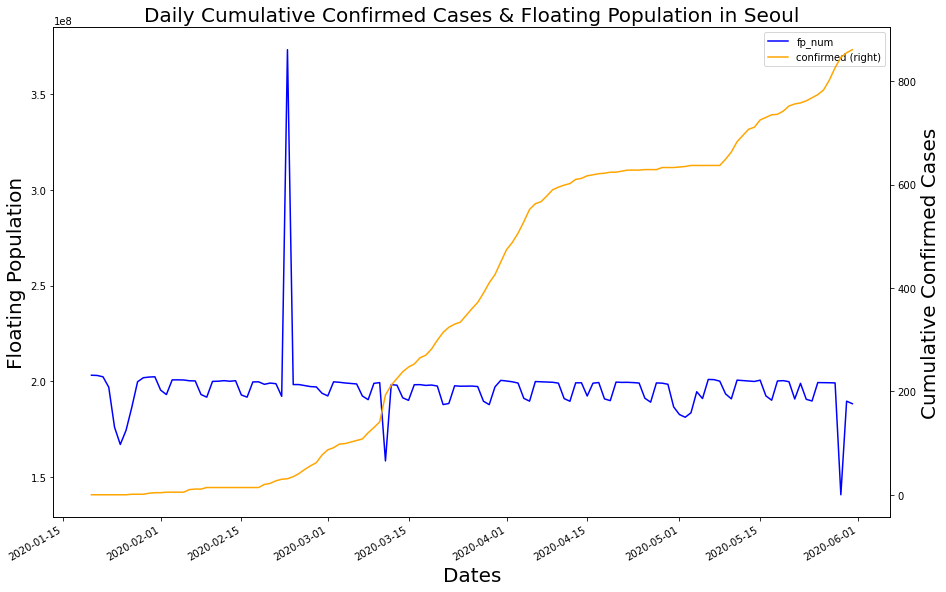

In [53]:
# 일별 누적확진자수와 서울 유동인구 추세 기본적인 그래프로 확인
fig, ax = plt.subplots(figsize=(15,10))
ax1 = seoul_fpnum_confirmed.plot(use_index=True,
                          kind='line',
                          y='fp_num',
                          color='blue',
                          ax=ax)
ax2 = seoul_fpnum_confirmed.plot(use_index=True,
                          kind='line',
                          y='confirmed',
                          color='orange',
                          secondary_y=True,
                          ax=ax)

ax.set_xlabel('Dates', fontsize=20)
ax1.set_ylabel('Floating Population', fontsize=20)
ax2.set_ylabel('Cumulative Confirmed Cases', fontsize=20)
ax.set_title('Daily Cumulative Confirmed Cases & Floating Population in Seoul', fontsize=20)
plt.show()

In [15]:
# 유동인구 중 outlier로 추측되는 부분 확인
seoul_fpnum_confirmed[seoul_fpnum_confirmed['fp_num'] > 3e8]

fp_num  confirmed
date                            
2020-02-23  373087550         31

#### 2월 23일에는 무슨 일이 있었던 것일까?
우선 2월 23일은 일요일이었습니다. 주말이란 점을 고려했을 때 서울 유동인구가 주말에 소폭 감소하는 추세를 보이지만 당일은 다른 날짜의 거의 2배 수준의 유동인구가 생겼습니다. 검색을 통해 확인해본 결과 특별한 점은 찾을 수 없었지만, 당시 최초 슈퍼전파자로 유명세를 탔던 `대구 신천지 교인 31번 확진자` 분의 사례가 그 즈음하여 주목받기 시작했고, 2월 19일엔 국내 첫 코로나 감염환자 중 사망자가 발생한 날이었습니다. 이럴수록 더 유동인구가 줄었어야 하는 것이 맞지만, 유동인구가 오히려 늘은 점에 대해선 다른 event와 연관성이 있지 않을까 싶습니다.

유동인구 값의 스케일이 너무 큰데, 유동인구 감소가 더 잘 발생했을 것으로 예상되는_(코로나 확진세는 계속 늘어가는 추세이므로)_ 후반부 부분을 정규화 후 확인해보도록 하겠습니다.

In [16]:
# 해당 컬럼을 스케일링
seoul_fpnum_confirmed['s_fp_num'] = (seoul_fpnum_confirmed['fp_num'] - seoul_fpnum_confirmed['fp_num'].mean()) / seoul_fpnum_confirmed['fp_num'].std()

seoul_fpnum_confirmed.head()

fp_num  confirmed  s_fp_num
date                                      
2020-01-20  203217220          0  0.382137
2020-01-21  203095360          0  0.375194
2020-01-22  202391580          0  0.335092
2020-01-23  196953190          0  0.025208
2020-01-24  176114510          0 -1.162194

<AxesSubplot:xlabel='date'>

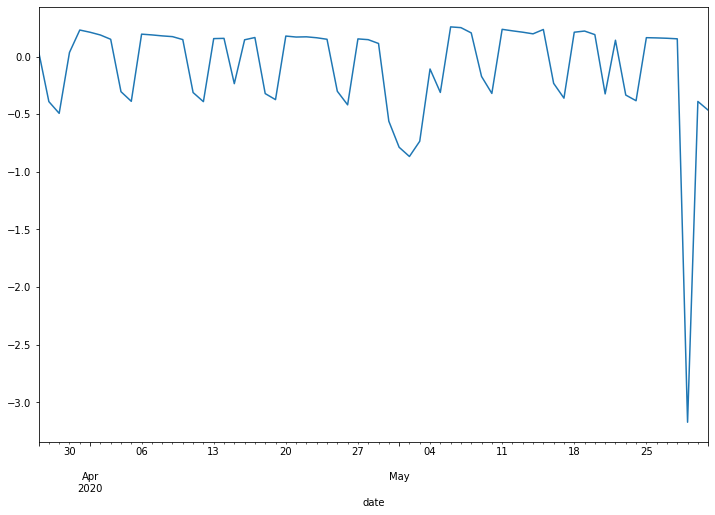

In [17]:
# 만약 감소폭이 있으면 후반부에 있을 테니 뒤의 약 절반만 확인
plt.figure(figsize=(12, 8))
seoul_fpnum_confirmed['s_fp_num'][len(seoul_fpnum_confirmed['s_fp_num'])//2:].plot()

일별 유동인구는 그래프 상에서 별다른 차이가 없는 것으로 보여 **유동인구 자체**의 정량적 분포를 히스토그램을 통해 확인해보겠습니다.

<AxesSubplot:xlabel='fp_num', ylabel='Count'>

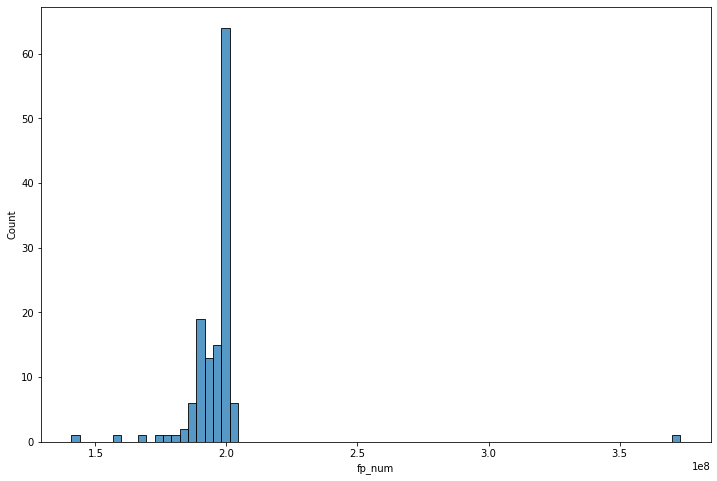

In [164]:
# 유동인구 데이터 자체의 분포 확인
compare_s = seoul_fpnum_confirmed['fp_num']

plt.figure(figsize=(12, 8))
sns.histplot(compare_s)

유동인구 자체로 히스토그램을 만들었을 때 대부분의 데이터들이 거의 한 곳에 모여 있는 것을 확인할 수 있습니다. 코로나 영향으로 유동인구가 낮아졌다면 낮은 숫자 쪽의 bin 크기가 커야 하는데 크기가 굉장히 작은 것을 볼 수 있습니다.

그렇다면 일별 유동인구와 일별 누적확진자 수는 정량적으로 어떤 상관관계를 갖는지 확인해보겠습니다.

In [19]:
# 상관관계 분석
seoul_fpnum_confirmed[['fp_num', 'confirmed']].corr()

fp_num  confirmed
fp_num     1.000000  -0.133613
confirmed -0.133613   1.000000

서울시 전반의 일별 유동인구와 일별 누적확진자 수는 `0`에 가까운 음수로서 강하지 않은 상관관계를 가지는 것이 보입니다. 그렇다면 혹시 서울시 전반의 **일별 유동인구와 일별 확진자 증가수**(누적확진자 수 말고)는 좀 더 상관관계를 갖고 있을까요? 둘 사이의 상관관계를 확인해보겠습니다.

In [20]:
# 일별 확진자 증가수 컬럼 만들기
seoul_fpnum_confirmed['daily_increase'] = seoul_fpnum_confirmed['confirmed'] - seoul_fpnum_confirmed['confirmed'].shift(1).fillna(0)

In [21]:
# 상관관계 분석
seoul_fpnum_confirmed[['fp_num', 'daily_increase']].corr()

fp_num  daily_increase
fp_num          1.000000       -0.179281
daily_increase -0.179281        1.000000

서울시 전반의 일별 유동인구와 일별 확진자 증가수 역시 `0`에 가까운 음수로서 약한 상관관계를 갖는 것을 볼 수 있습니다.

### 결론
-----
**전반적인 서울시의 확진자 수 증가는 유동인구 감소에 영향을 주지 않고 있는 것으로 보입니다.** 

하지만 구별 유동인구라는 데이터가 있으니 구별 확진자수 데이터만 있으면 좀 더 세분화된 지역별 확진자수 증가와 유동인구 사이의 관계를 파악할 수 있을 것 같습니다. 이에 공공데이터 중 해당 자료가 있는 것을 확보하여 서울시 구별 유동인구 및 확진자 수 사이의 관계를 파악해보도록 하겠습니다. 예상하기로는 시단위로 봤을 때보다 좀 더 세분화된 지역 내 코로나 감염 정보이므로, 더 밀접한 유동인구와 확진자 수 사이의 관계를 볼 수 있지 않을까 생각합니다. 현재 확인해보려는 가설은 **'시단위보다 작은 단위인 구별 확진자 증가폭은 체감상 더 가깝게 느껴지기 때문에 구별 유동인구 감소에 영향을 끼쳤을 것이다.'** 입니다.

### 데이터 시각화 (2)
- 서울시 구별 일별 유동인구 
---

In [22]:
# 외부데이터 가져오기
# http://data.seoul.go.kr/dataList/OA-20470/S/1/datasetView.do

subregion_cases = pd.read_csv(os.path.join(file_path, 'public_subregion.csv'), parse_dates=[0])

In [23]:
# 데이터프레임 자료형 확인
subregion_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 53 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   자치구 기준일  763 non-null    datetime64[ns]
 1   종로구 전체   763 non-null    int64         
 2   종로구 추가   763 non-null    int64         
 3   중구 전체    763 non-null    int64         
 4   중구 추가    763 non-null    int64         
 5   용산구 전체   763 non-null    int64         
 6   용산구 추가   763 non-null    int64         
 7   성동구 전체   763 non-null    int64         
 8   성동구 추가   763 non-null    int64         
 9   광진구 전체   763 non-null    int64         
 10  광진구 추가   763 non-null    int64         
 11  동대문구 전체  763 non-null    int64         
 12  동대문구 추가  763 non-null    int64         
 13  중랑구 전체   763 non-null    int64         
 14  중랑구 추가   763 non-null    int64         
 15  성북구 전체   763 non-null    int64         
 16  성북구 추가   763 non-null    int64         
 17  강북구 전체   763 non-null    int64     

결측치가 없는 것과 `자치구 기준일`을 제외한 나머지 칼럼의 자료형이 계산하기 좋은 `int64`임을 확인할 수 있습니다.

In [24]:
# 제일 오래된 날짜 확인
subregion_cases['자치구 기준일'].min()

Timestamp('2005-02-20 10:00:00')

In [25]:
# 기존 데이터와 날짜 범위를 맞춰주기 위해 전처리
# 시작 및 끝 날짜 자료형 만들기
start_date_str = '2020-01-20'
end_date_str = '2020-05-30'
start_date = dt.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')

start_date, end_date

(datetime.datetime(2020, 1, 20, 0, 0), datetime.datetime(2020, 5, 30, 0, 0))

In [26]:
# 기존 데이터 날짜 range에 들어오는 날짜 데이터만 가져오기
subregion_cases = subregion_cases[(end_date >= subregion_cases['자치구 기준일']) & (start_date <= subregion_cases['자치구 기준일'])]

In [27]:
subregion_cases.describe()

종로구 전체     종로구 추가      중구 전체      중구 추가     용산구 전체     용산구 추가  \
count  93.000000  93.000000  93.000000  93.000000  93.000000  93.000000   
mean   14.634409   0.107527   4.419355   0.096774  16.000000   0.408602   
std     2.665337   0.428911   2.920403   0.297252  12.118975   0.946809   
min     8.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%    11.000000   0.000000   1.000000   0.000000   5.000000   0.000000   
50%    16.000000   0.000000   5.000000   0.000000  17.000000   0.000000   
75%    16.000000   0.000000   6.000000   0.000000  19.000000   0.000000   
max    18.000000   3.000000   9.000000   1.000000  38.000000   4.000000   

          성동구 전체     성동구 추가     광진구 전체     광진구 추가  ...     서초구 전체     서추구 추가  \
count  93.000000  93.000000  93.000000  93.000000  ...  93.000000  93.000000   
mean   13.301075   0.408602   6.827957   0.150538  ...  27.290323   0.419355   
std     8.929415   1.085843   3.749271   0.388594  ...  14.402280   0.825182   
min     1.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
25%     5.000000   0.000000   4.000000   0.000000  ...  11.000000   0.000000   
50%    16.000000   0.000000   8.000000   0.000000  ...  36.000000   0.000000   
75%    20.000000   0.000000   8.000000   0.000000  ...  38.000000   1.000000   
max    39.000000   8.000000  14.000000   2.000000  ...  42.000000   4.000000   

          강남구 전체     강남구 추가     송파구 전체     송파구 추가     강동구 전체     강동구 추가  \
count  93.000000  93.000000  93.000000  93.000000  93.000000  93.000000   
mean   45.494624   0.752688  29.978495   0.408602  11.698925   0.225806   
std    24.433861   1.221687  12.077628   0.769480   5.669876   0.469251   
min     0.000000   0.000000   1.000000   0.000000   0.000000   0.000000   
25%    17.000000   0.000000  18.000000   0.000000   7.000000   0.000000   
50%    59.000000   0.000000  37.000000   0.000000  13.000000   0.000000   
75%    64.000000   1.000000  37.000000   1.000000  14.000000   0.000000   
max    72.000000   5.000000  47.000000   4.000000  24.000000   2.000000   

           기타 전체      기타 추가  
count  93.000000  93.000000  
mean   34.881720   0.548387  
std    14.655352   1.005594  
min     3.000000   0.000000  
25%    19.000000   0.000000  
50%    43.000000   0.000000  
75%    45.000000   1.000000  
max    57.000000   6.000000  

[8 rows x 52 columns]

In [28]:
# 전체적인 데이터프레임 확인
subregion_cases.head()

자치구 기준일  종로구 전체  종로구 추가  중구 전체  중구 추가  용산구 전체  용산구 추가  성동구 전체  \
648 2020-05-29 10:00:00      18       0      9      1      38       0      39   
649 2020-05-28 10:00:00      18       0      8      0      38       0      37   
650 2020-05-27 10:00:00      18       0      8      0      38       0      34   
651 2020-05-26 10:00:00      18       0      8      0      38       0      26   
652 2020-05-25 10:00:00      18       0      8      0      38       0      23   

     성동구 추가  광진구 전체  ...  서초구 전체  서추구 추가  강남구 전체  강남구 추가  송파구 전체  송파구 추가  \
648       2      14  ...      42       0      72       0      47       1   
649       3      14  ...      42       0      72       0      46       1   
650       8      13  ...      42       0      72       0      45       0   
651       3      13  ...      42       0      72       0      45       0   
652       1      13  ...      42       0      72       0      45       0   

     강동구 전체  강동구 추가  기타 전체  기타 추가  
648      24       0     57      2  
649      24       1     55      3  
650      23       0     52      1  
651      23       1     51      0  
652      22       0     51      0  

[5 rows x 53 columns]

기존 데이터와 같이 호환하려면 날짜 관련한 컬럼으로 엮을 수 있습니다. 현재 데이터의 날짜는 기존 데이터 샘플 **132개** 중 **93개**의 날짜와 일치합니다. 날짜가 일치하지 않는 행의 경우 구별 확진자수 컬럼을 추가하면 NaN 값이 발생하므로 겹치는 날짜만 보도록 하겠습니다.

#### 구 이름을 기준으로 두 데이터프레임 합치기

In [29]:
# 기존 데이터의 구 이름 확인
float_df['city'].unique()

array(['Dobong-gu', 'Dongdaemun-gu', 'Dongjag-gu', 'Eunpyeong-gu',
       'Gangbuk-gu', 'Gangdong-gu', 'Gangnam-gu', 'Gangseo-gu',
       'Geumcheon-gu', 'Guro-gu', 'Gwanak-gu', 'Gwangjin-gu', 'Jongno-gu',
       'Jung-gu', 'Jungnang-gu', 'Mapo-gu', 'Nowon-gu', 'Seocho-gu',
       'Seodaemun-gu', 'Seongbuk-gu', 'Seongdong-gu', 'Songpa-gu',
       'Yangcheon-gu', 'Yeongdeungpo-gu', 'Yongsan-gu'], dtype=object)

In [30]:
# 새로운 데이터의 구 이름 확인
subregion_cases.columns[1:]

Index(['종로구 전체', '종로구 추가', '중구 전체', '중구 추가', '용산구 전체', '용산구 추가', '성동구 전체',
       '성동구 추가', '광진구 전체', '광진구 추가', '동대문구 전체', '동대문구 추가', '중랑구 전체', '중랑구 추가',
       '성북구 전체', '성북구 추가', '강북구 전체', '강북구 추가', '도봉구 전체', '도봉구 추가', '노원구 전체',
       '노원구 추가', '은평구 전체', '은평구 추가', '서대문구 전체', '서대문구 추가', '마포구 전체', '마포구 추가',
       '양천구 전체', '양천구 추가', '강서구 전체', '강서구 추가', '구로구 전체', '구로구 추가', '금천구 전체',
       '금천구 추가', '영등포구 전체', '영등포구 추가', '동작구 전체', '동작구 추가', '관악구 전체', '관악구 추가',
       '서초구 전체', '서추구 추가', '강남구 전체', '강남구 추가', '송파구 전체', '송파구 추가', '강동구 전체',
       '강동구 추가', '기타 전체', '기타 추가'],
      dtype='object')

In [31]:
# 기존 데이터의 영문 구 이름으로 맞추기 위한 딕셔너리 생성
# 구별 3개의 데이터가 있는데, 이 중 기존 데이터의 성격과 맞는
# '~~~ 전체' 데이터, 즉 누적확진자 수를 가져오기로 한다.
gu_dict = {'종로구 전체':'Jongno-gu',
          '중구 전체':'Jung-gu',
          '용산구 전체':'Yongsan-gu',
          '성동구 전체':'Seongdong-gu',
          '광진구 전체':'Gwangjin-gu',
          '동대문구 전체':'Dongdaemun-gu',
          '중랑구 전체':'Jungnang-gu',
          '성북구 전체':'Seongbuk-gu',
          '강북구 전체':'Gangbuk-gu',
          '도봉구 전체':'Dobong-gu',
          '노원구 전체':'Nowon-gu',
          '은평구 전체':'Eunpyeong-gu',
          '서대문구 전체':'Seodaemun-gu',
          '마포구 전체':'Mapo-gu',
          '양천구 전체':'Yangcheon-gu',
          '강서구 전체':'Gangseo-gu',
          '구로구 전체':'Guro-gu',
          '금천구 전체':'Geumcheon-gu',
          '영등포구 전체':'Yeongdeungpo-gu',
          '동작구 전체':'Dongjag-gu',
          '관악구 전체':'Gwanak-gu',
          '서초구 전체':'Seocho-gu',
          '강남구 전체':'Gangnam-gu',
          '송파구 전체':'Songpa-gu',
          '강동구 전체':'Gangdong-gu'}

In [32]:
# 개수 맞는지 확인
len(gu_dict) == float_df['city'].nunique()

True

In [33]:
# 새로운 데이터프레임 내 해당 컬럼들 영문으로 변경
subregion_cases.rename(columns=gu_dict, inplace=True)

In [34]:
# 한글 인덱스도 변경
subregion_cases.rename(columns={'자치구 기준일':'date'}, inplace=True)

In [35]:
# 자료형에서 date만 나오도록 변경(추후 합칠 때 같은 자료형이 되도록)
subregion_cases['date'] = subregion_cases['date'].map(lambda x: dt.datetime(x.year, x.month, x.day))

In [36]:
# '~~구 추가', '기타 전체', '기타 추가'를 제외한 컬럼만 남기기
subregion_cases = subregion_cases[['date'] + list(gu_dict.values())]

In [37]:
# 합칠 데이터프레임 준비(1)
# 유동인구 데이터에서 date와 city를 기준으로 유동인구가 나오도록 한다.
to_combine_1 = float_df.groupby(['date', 'city']).sum().reset_index()
to_combine_1.head()

date           city  hour  birth_year   fp_num
0 2020-01-01      Dobong-gu  3312       12960  6285430
1 2020-01-01  Dongdaemun-gu  3312       12960  6918490
2 2020-01-01     Dongjag-gu  3312       12960  7669030
3 2020-01-01   Eunpyeong-gu  3312       12960  8780930
4 2020-01-01     Gangbuk-gu  3312       12960  6160610

In [38]:
# 합칠 데이터프레임 준비(2)
# 일별지역별 확진자 수 데이터에서 date와 city를 기준으로 확진자 수가 나오도록 한다.
to_combine_2 = subregion_cases.melt(id_vars='date', var_name='city', value_name='confirmed').sort_values(by='date')
to_combine_2.head()

date         city  confirmed
2324 2020-02-20  Gangdong-gu          0
2231 2020-02-20    Songpa-gu          1
2138 2020-02-20   Gangnam-gu          0
185  2020-02-20      Jung-gu          0
2045 2020-02-20    Seocho-gu          0

In [39]:
# 합치기
gu_fpnum_confirmed = pd.merge(to_combine_1, to_combine_2, on=['date', 'city'])
gu_fpnum_confirmed.head()

date           city  hour  birth_year   fp_num  confirmed
0 2020-02-20      Dobong-gu  3312       12960  5385440          0
1 2020-02-20  Dongdaemun-gu  3312       12960  6854800          0
2 2020-02-20     Dongjag-gu  3312       12960  7328200          0
3 2020-02-20   Eunpyeong-gu  3312       12960  7660360          0
4 2020-02-20     Gangbuk-gu  3312       12960  5482400          0

In [40]:
# 뒷날짜 확인
gu_fpnum_confirmed.tail()

date             city  hour  birth_year   fp_num  confirmed
2295 2020-05-29     Seongdong-gu  1632        9180  4468680         39
2296 2020-05-29        Songpa-gu  1632        9180  8801920         47
2297 2020-05-29     Yangcheon-gu  1632        9180  5329550         27
2298 2020-05-29  Yeongdeungpo-gu  1632        9180  7080190         31
2299 2020-05-29       Yongsan-gu  1632        9180  3694630         38

#### 시각화

In [41]:
# 함수화
def gu_graph(gu):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax1 = gu_fpnum_confirmed[gu_fpnum_confirmed['city'] == gu].plot(use_index=False,
                                                                            kind='line',
                                                                            x='date',
                                                                            y='fp_num',
                                                                            color='blue',
                                                                            ax=ax)
    ax2 = gu_fpnum_confirmed[gu_fpnum_confirmed['city'] == gu].plot(use_index=False,
                                                                            kind='line',
                                                                            x='date',
                                                                            y='confirmed',
                                                                            color='orange',
                                                                            ax=ax,
                                                                            secondary_y=True)

    ax.set_xlabel('Dates', fontsize=20)
    ax1.set_ylabel('Floating Population', fontsize=20)
    ax2.set_ylabel('Cumulative Confirmed Cases', fontsize=20)
    ax.set_title(f'Daily Cumulative Confirmed Cases & Floating Population in {gu}', fontsize=20)
    plt.show()

In [42]:
# 지역별 이름 예시 보기
gu_list = list(gu_dict.values())
gu_list[:5]

['Jongno-gu', 'Jung-gu', 'Yongsan-gu', 'Seongdong-gu', 'Gwangjin-gu']

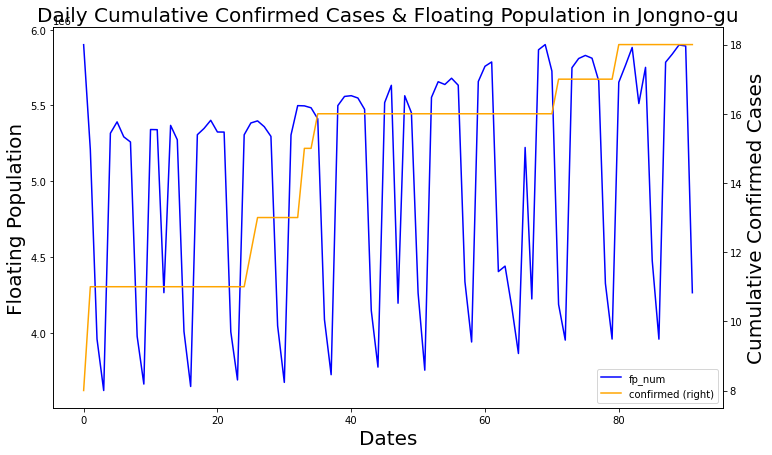

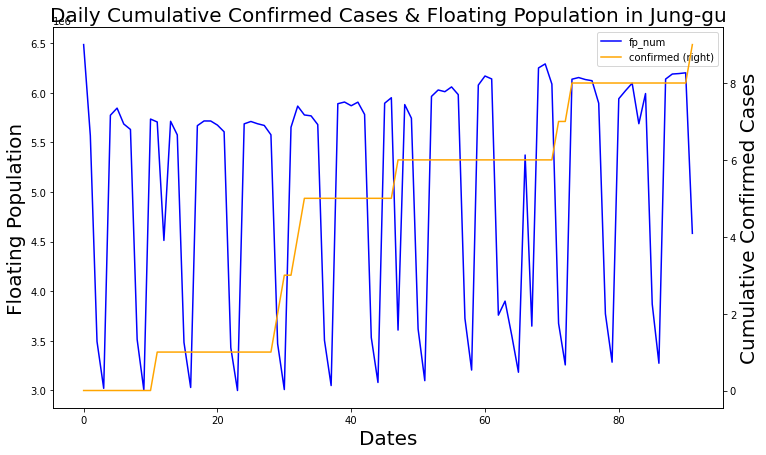

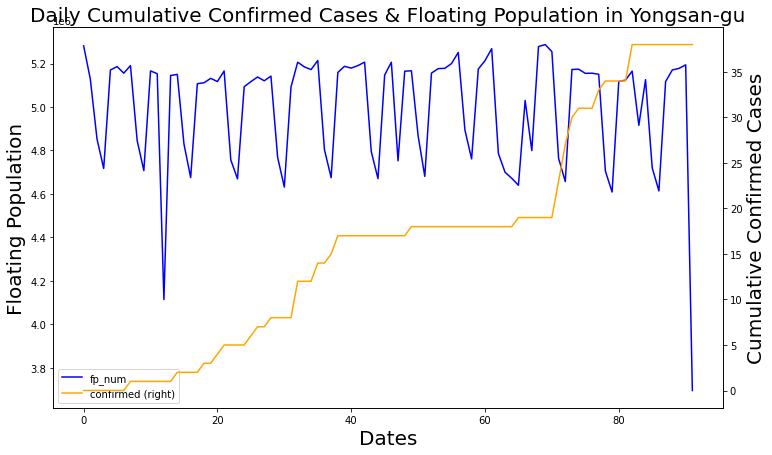

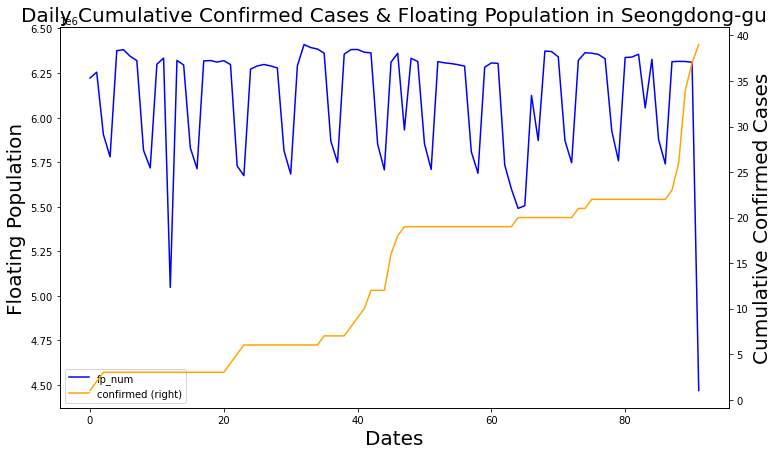

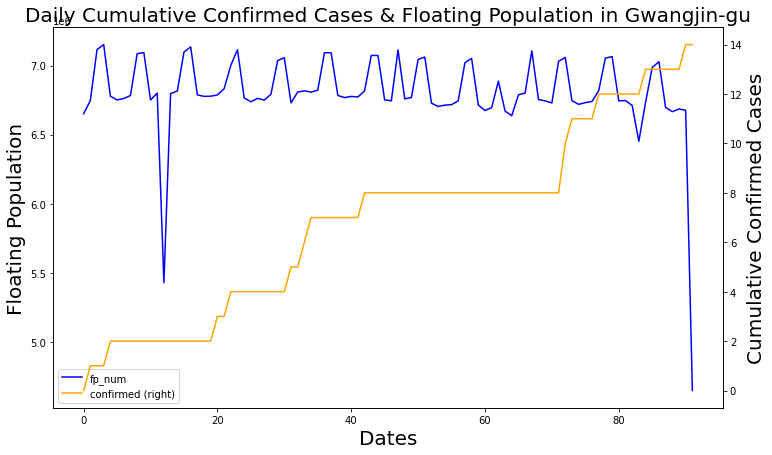

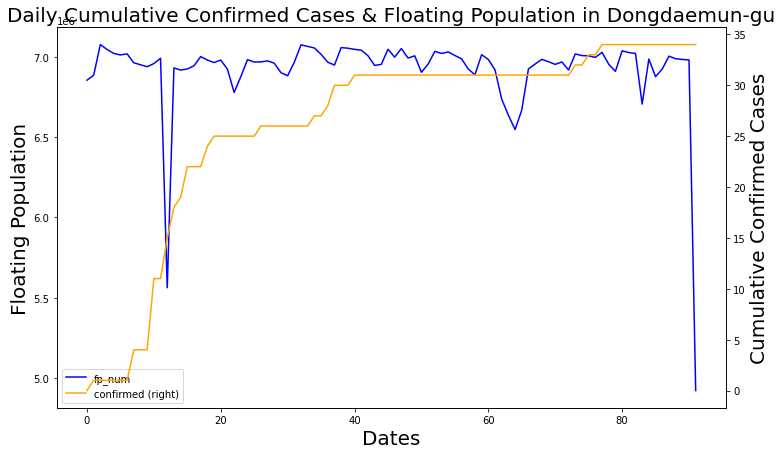

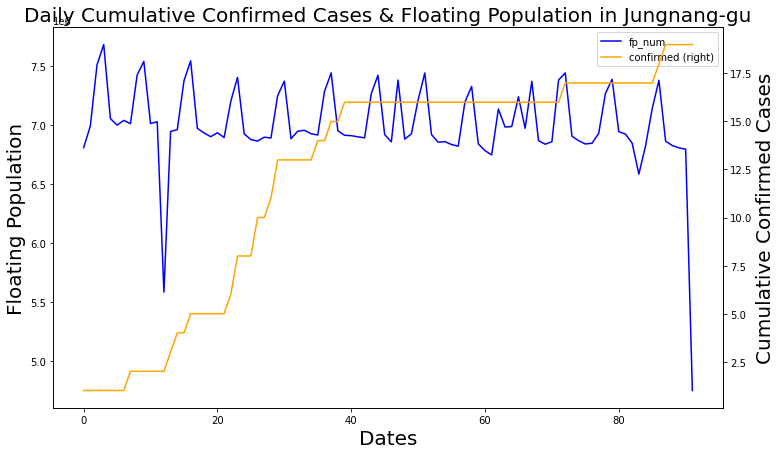

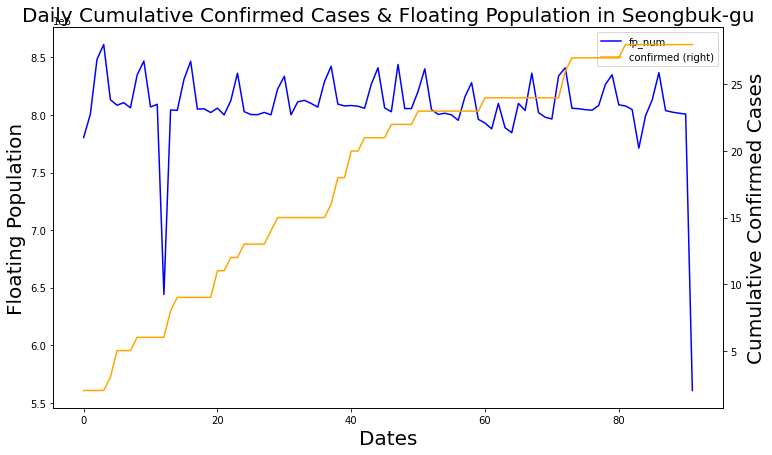

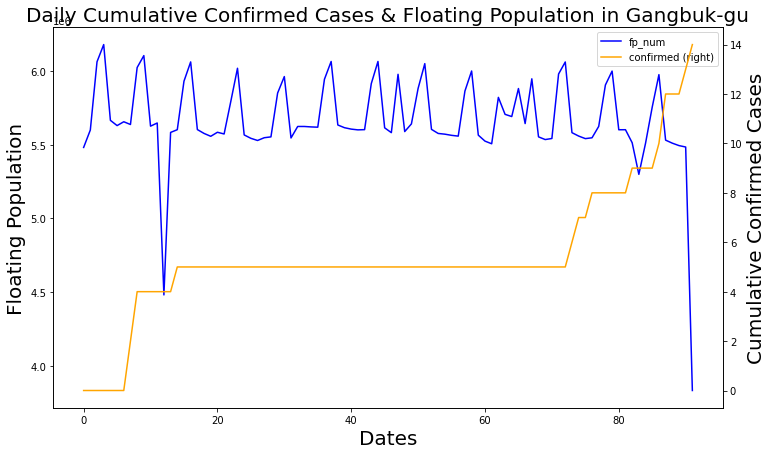

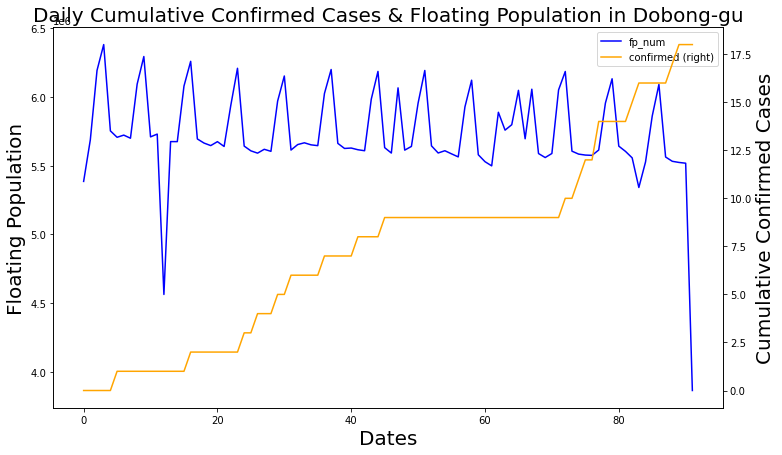

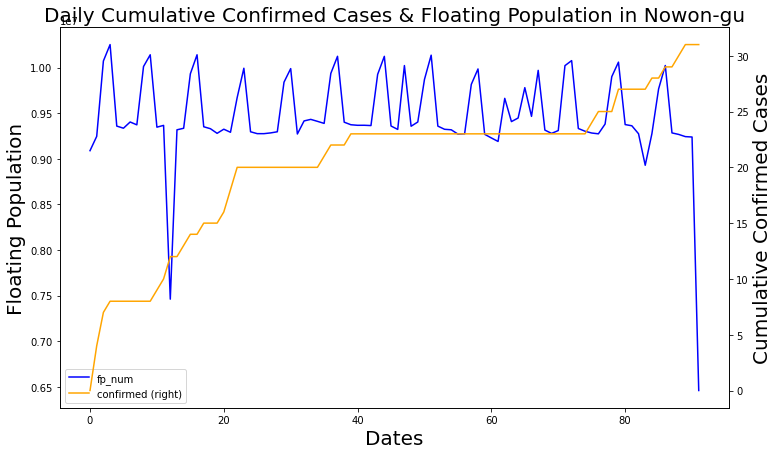

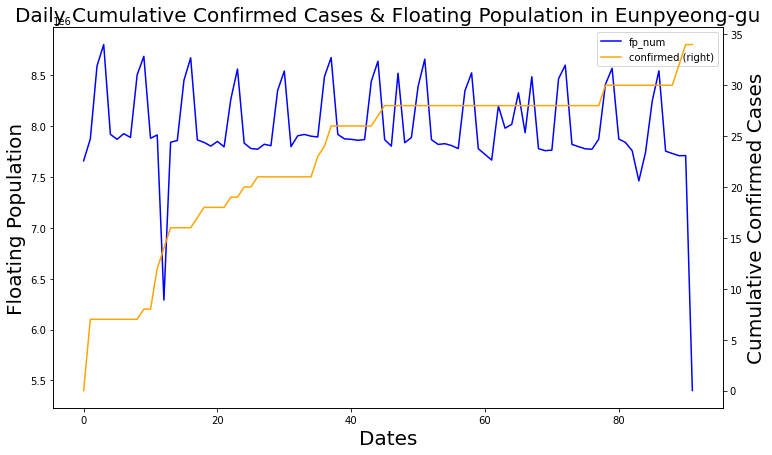

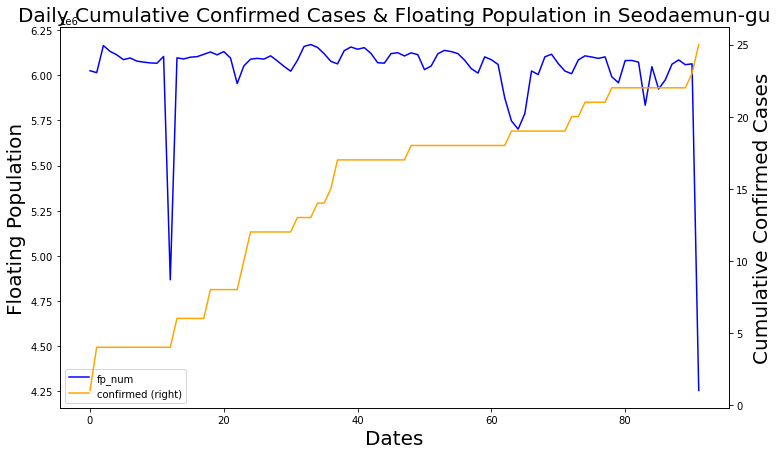

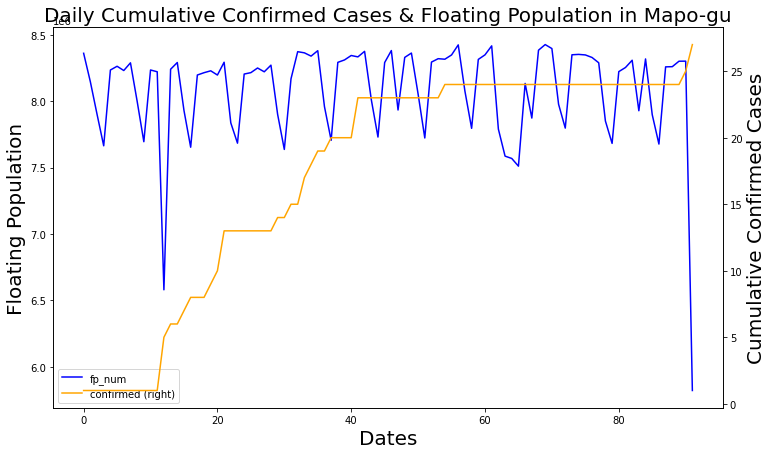

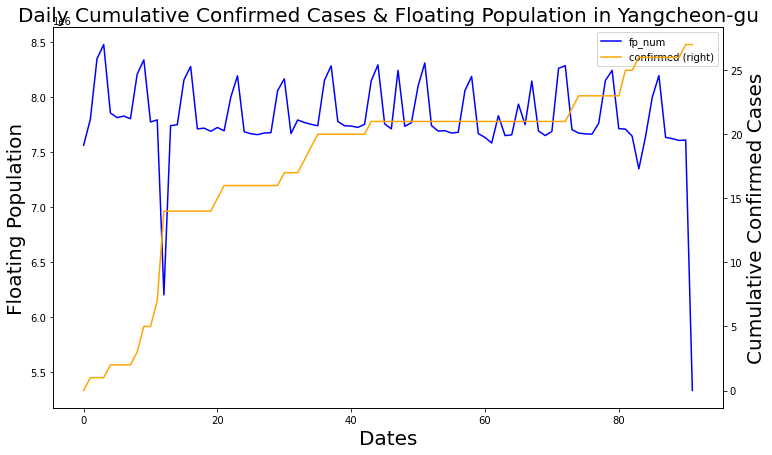

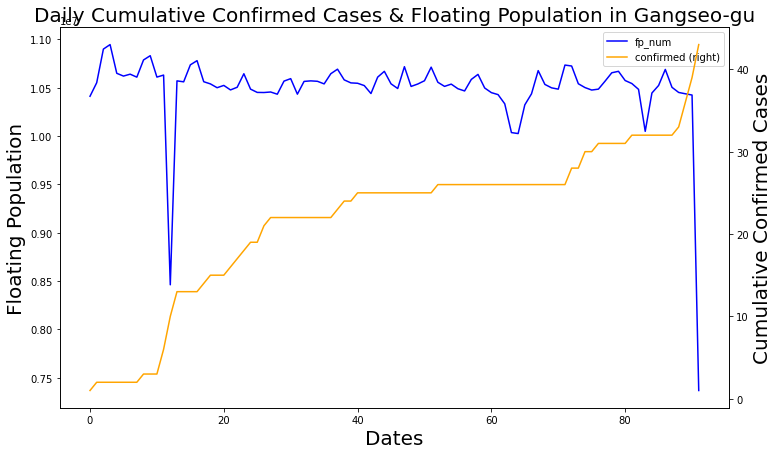

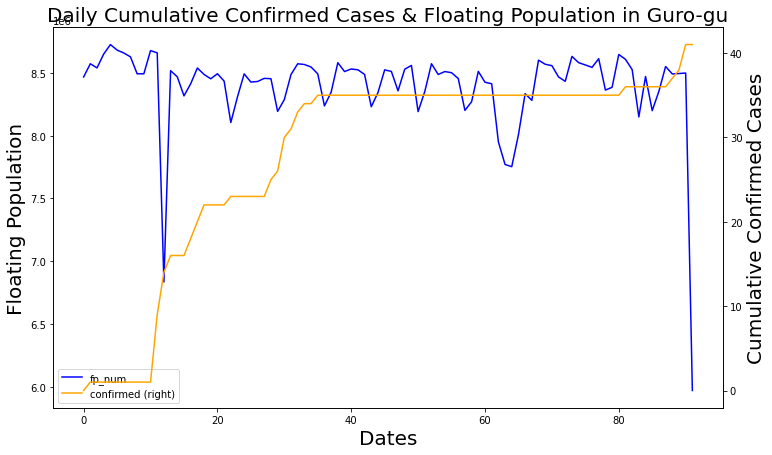

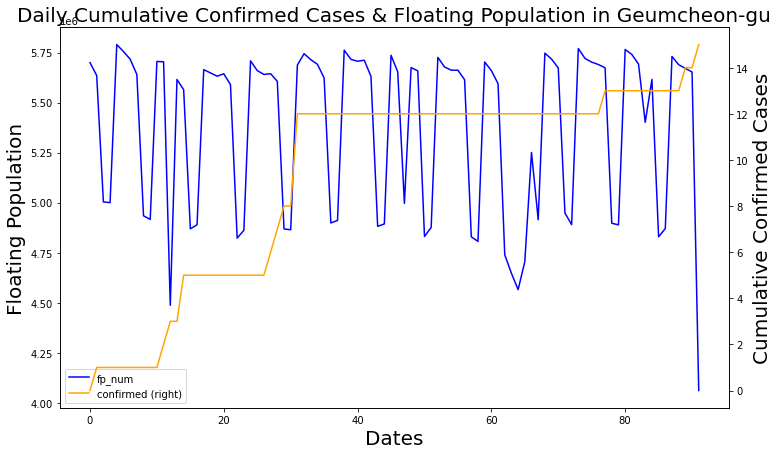

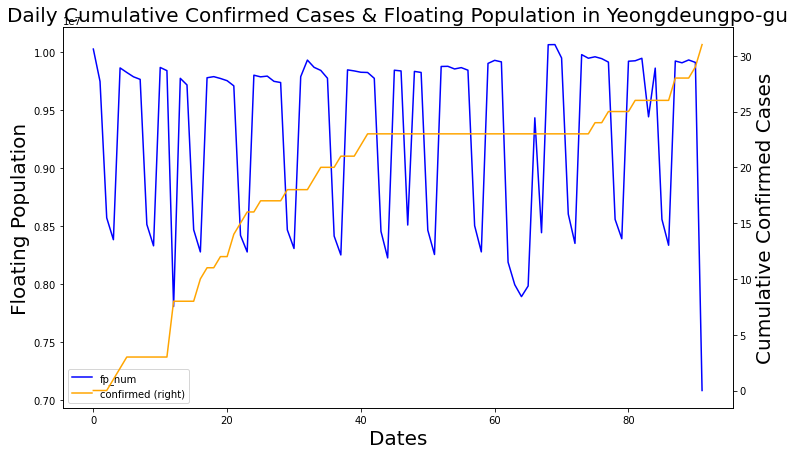

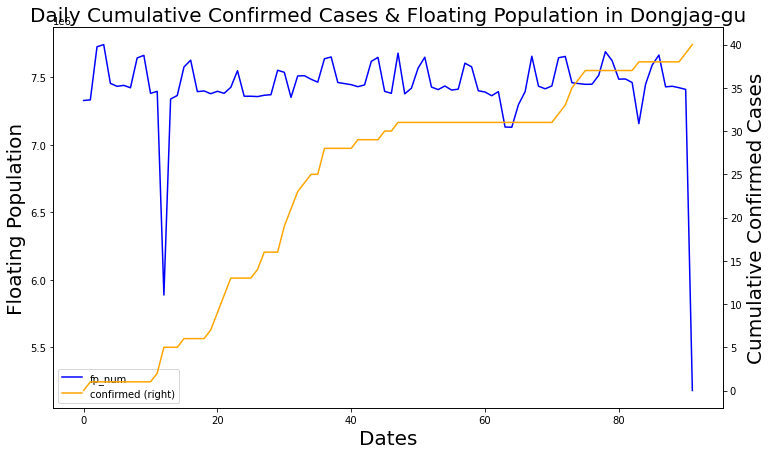

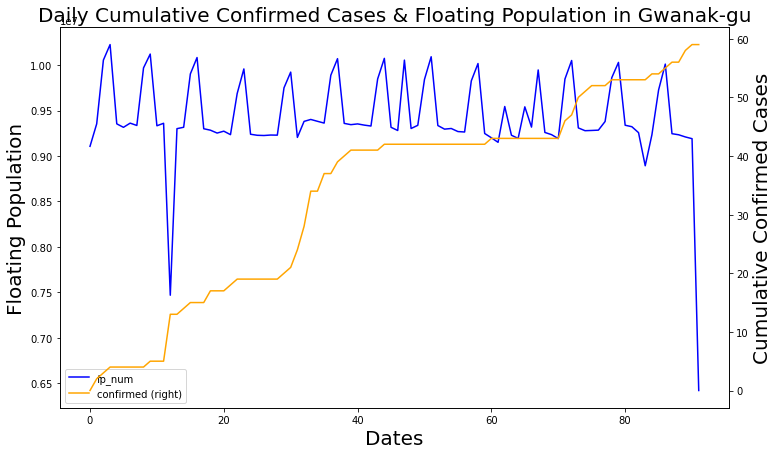

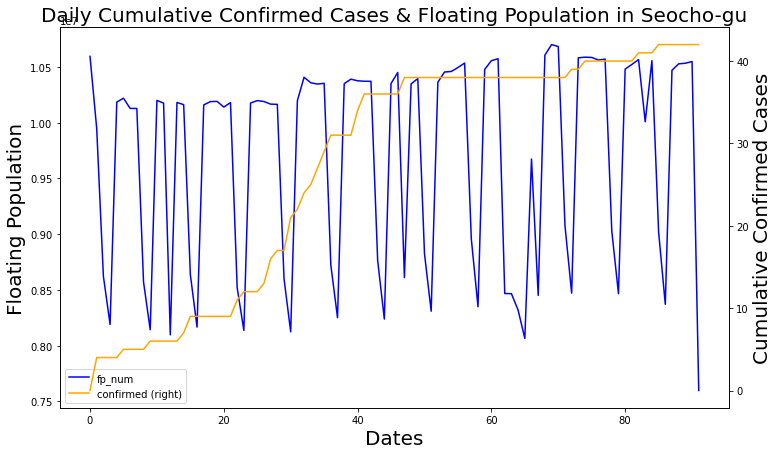

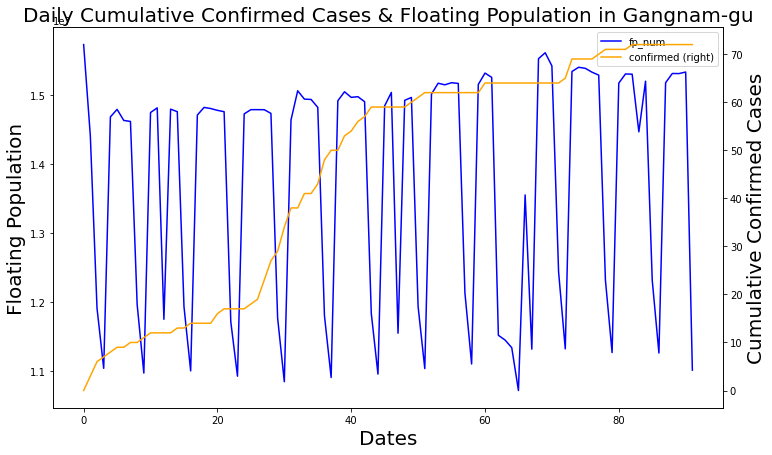

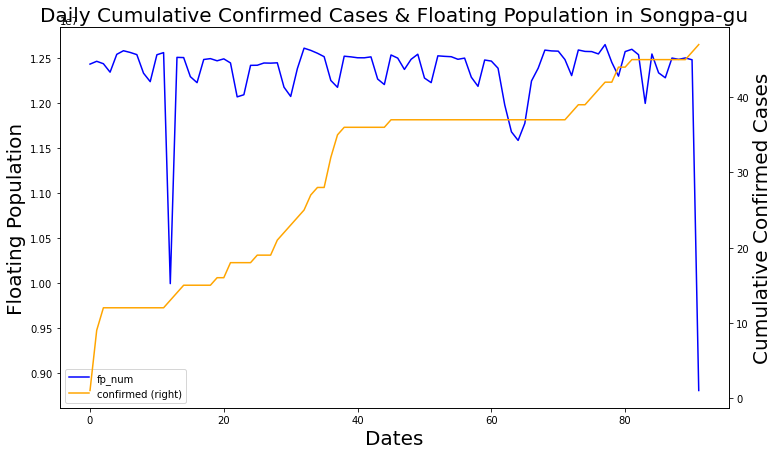

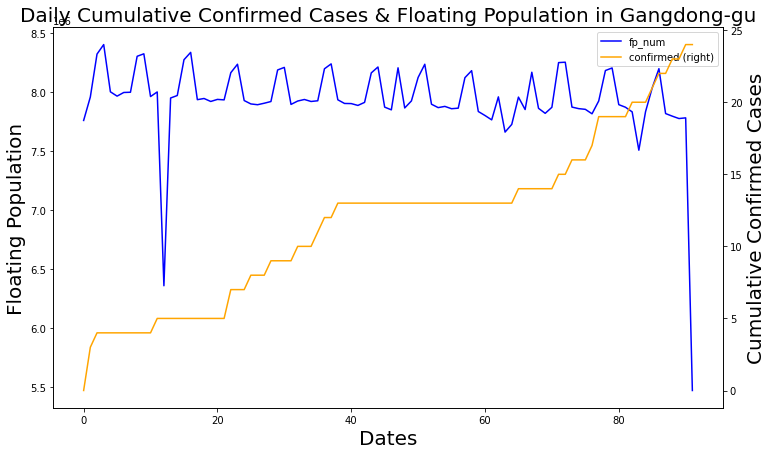

In [43]:
# 25개의 구에 대한 구별 일별 유동인구 및 코로나 누적확진자수 확인
for gu in gu_list:
    gu_graph(gu)

In [44]:
# 유동인구가 급감하는 날짜 확인
gu_fpnum_confirmed[(gu_fpnum_confirmed['city'] == 'Gangbuk-gu') & (gu_fpnum_confirmed['fp_num'] < 4.8e6)]

date        city  hour  birth_year   fp_num  confirmed
304  2020-03-11  Gangbuk-gu  3312       12960  4480560          4
2279 2020-05-29  Gangbuk-gu  1632        9180  3831210         14

### 결론
---
전반적으로 봤을 때 유동인구 패턴으로 보아 구는 크게 2종류인 `비즈니스 지역`과 `주거 지역`으로 나눌 수 있을 것 같습니다. 또한, 전반적으로 봤을 때 `2020년 2월 20일부터 5월 29일`까지 일별 코로나 누적확진수 추세를 보면 `4월 초부터 4월 말 사이`에는 코로나 확진자 수의 증가폭이 다소 **추스러드는** 것을 볼 수 있고, `3월 초경(3월 11일)과 5월 말경(5월 29일)`에 유동인구의 **급감**하는 날이 있습니다.

대표적인 **비즈니스 지역**인 `종로구`, `중구`, `강남구`, `서초구` 등은 유동인구의 일별 차이가 평일과 주말시 많이 차이나는 것으로 나타나고, 동시에 2020년 2월 중순부터 5월 말까지의 기간 중 코로나 확진자 수가 급증하는 시기와 그 이후에도 유동인구에는 별다른 감소세를 보이지 않습니다. 반대로, 대표적인 **주거 지역**인 `성북구`, `광진구`, `강동구` 등은 유동인구의 일별 차이가 비즈니스 지역의 차이만큼 평일과 주말시 크게 나타나지 **않고**, 동시에 이 중 몇몇 지역은 후반부 날짜에 갈수록 정말 극소한 차이로 유동인구의 감소세를 보이기도 합니다.(`도봉구`, `강서구`)

이를 정량적인 지표로 확인해보도록 하겠습니다.

#### 상관관계 분석

In [45]:
# 구별 일별 유동인구와 누적확진자 수 사이의 상관관계를 히트맵으로 보는 함수 정의
def gu_corr_heatmap(gu, ax=None):
    hm = sns.heatmap(gu_fpnum_confirmed.loc[gu_fpnum_confirmed['city'] == gu, ['fp_num', 'confirmed']].corr(), annot=True, ax=ax)
    hm.set_title(f'{gu}', fontsize=14)

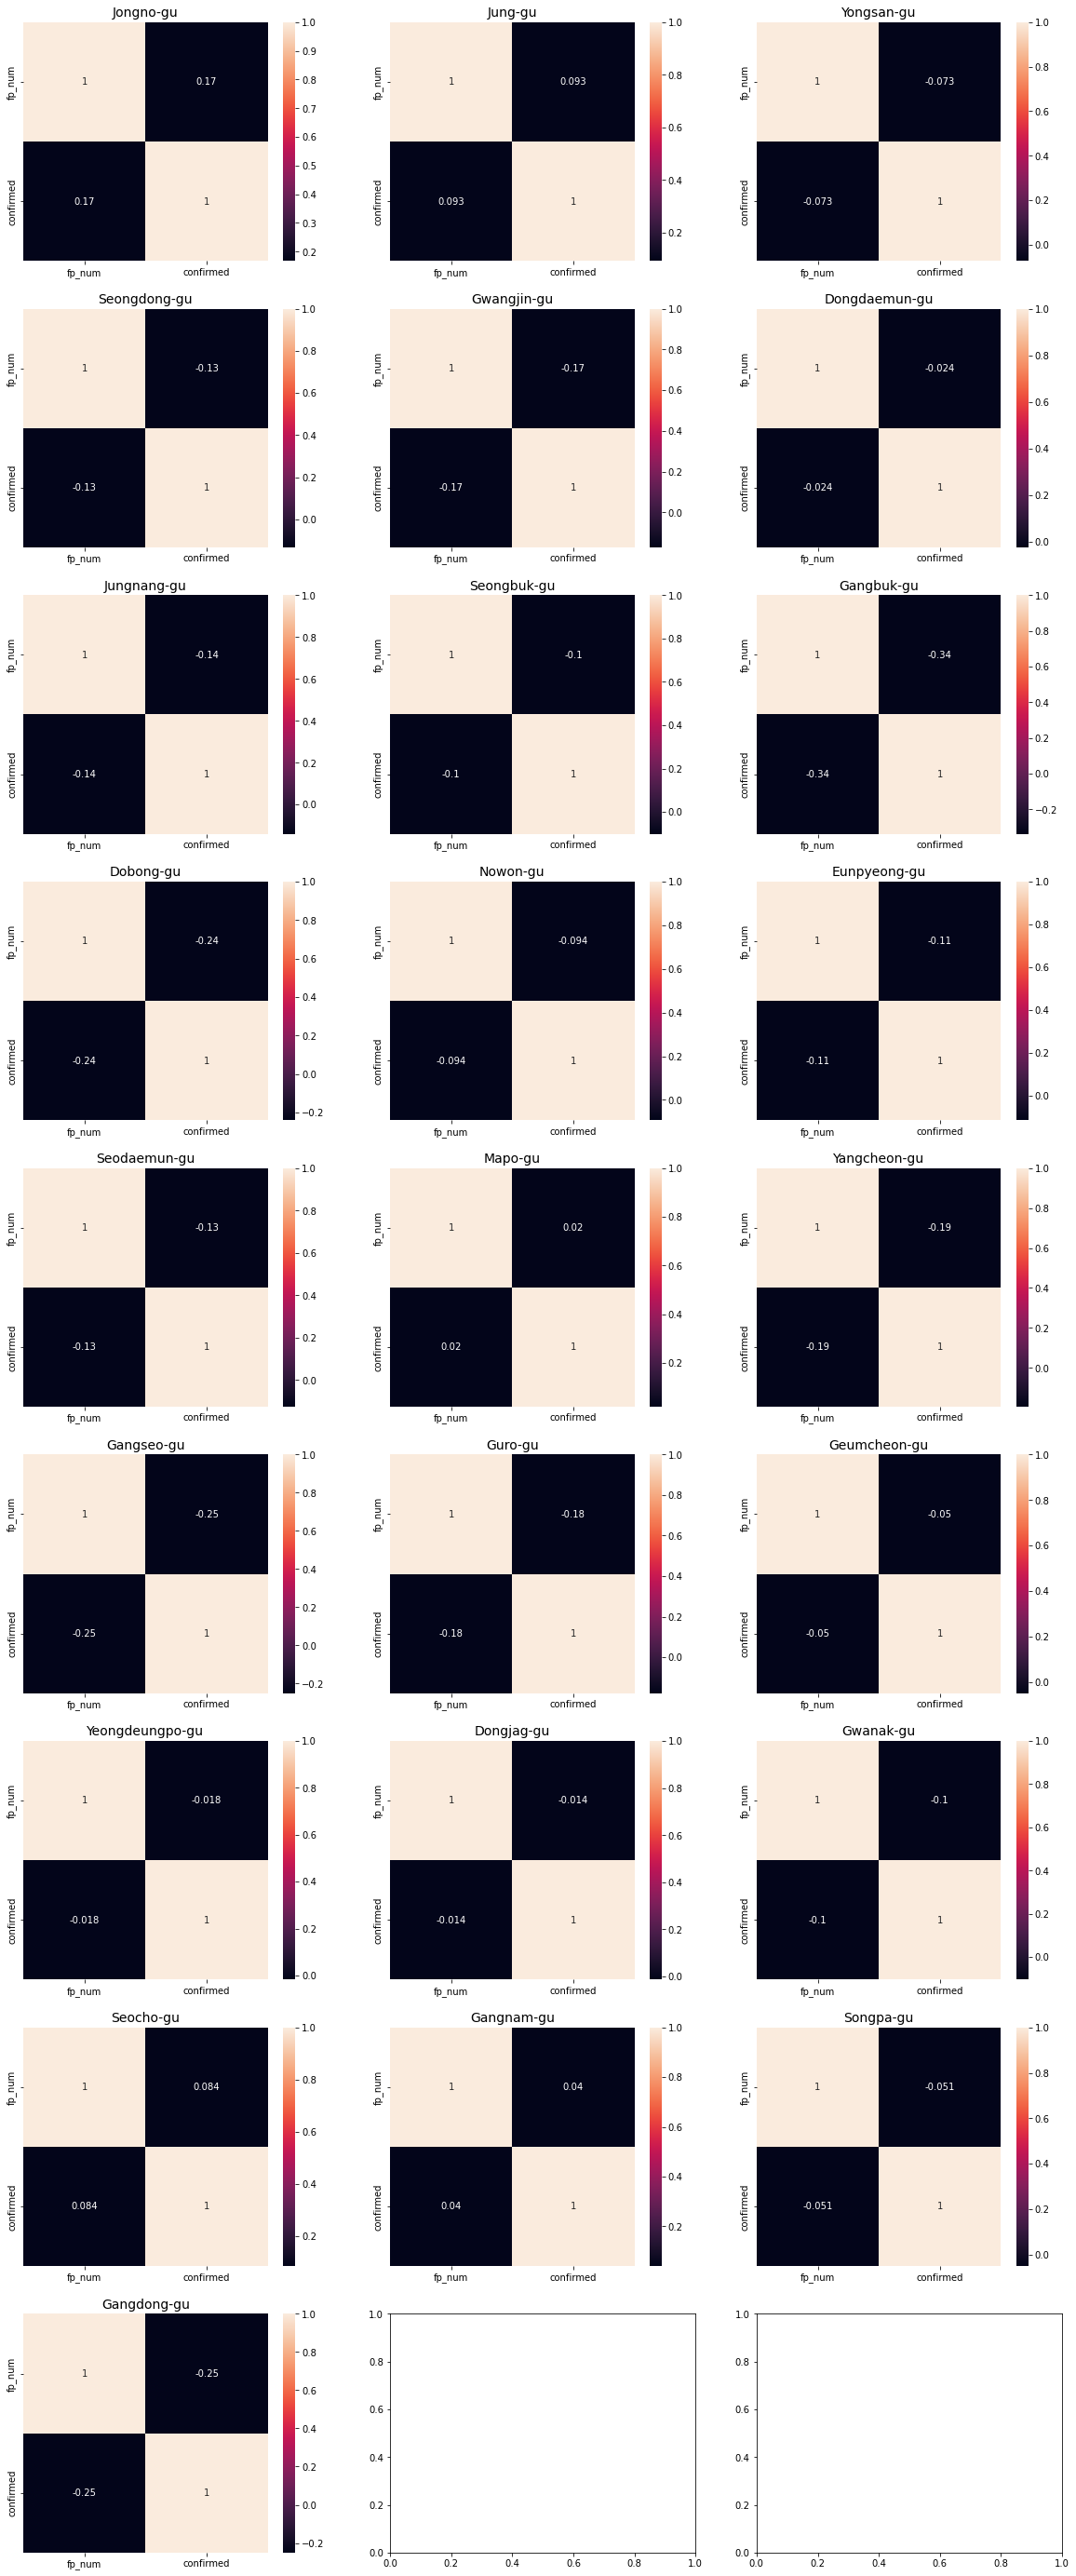

In [46]:
# 시각화하기
fig, axes = plt.subplots(9, 3, figsize=(20, 50))
for idx, gu in enumerate(gu_list):
    gu_corr_heatmap(gu, axes[idx // 3][idx % 3])
    if idx == 25:
        break

plt.show()

### 결론
---
**정석적인 그래프와 정량적인 상관관계를 토대로 봤을 때 서울 내 구별 유동인구와 코로나 누적확진자 수는 뚜렷한 상관관계가 없다고 결론 내릴 수 있을 것 같습니다.**

하지만 유동인구 데이터에 유동인구를 나이대별로 나눈 컬럼이 있습니다. 보통 젊은 연령층이 고령층보다 더 활동성이 높으므로 나이대를 구분해서 비교해본다면 고령층에서나마 유동인구의 감소세를 확인할 수 있지 않을까요? 코로나 누적확진자 수는 연령대 별로 데이터가 나뉘어 있지 않은 만큼, `전체적인 구별 코로나 누적확진자수에 따른 해당 구의 연령대별 유동인구 추이`를 좀 더 나아가서 확인해보도록 하겠습니다.

### 데이터 시각화 (3)
- 서울시 구별 일별 확진자 수 증가에 따른 해당 구별 연령대별 유동인구 추이 파악
---

In [58]:
# 합칠 데이터프레임 준비 (1)
gu_fpnum_confirmed

date             city  hour  birth_year   fp_num  confirmed
0    2020-02-20        Dobong-gu  3312       12960  5385440          0
1    2020-02-20    Dongdaemun-gu  3312       12960  6854800          0
2    2020-02-20       Dongjag-gu  3312       12960  7328200          0
3    2020-02-20     Eunpyeong-gu  3312       12960  7660360          0
4    2020-02-20       Gangbuk-gu  3312       12960  5482400          0
...         ...              ...   ...         ...      ...        ...
2295 2020-05-29     Seongdong-gu  1632        9180  4468680         39
2296 2020-05-29        Songpa-gu  1632        9180  8801920         47
2297 2020-05-29     Yangcheon-gu  1632        9180  5329550         27
2298 2020-05-29  Yeongdeungpo-gu  1632        9180  7080190         31
2299 2020-05-29       Yongsan-gu  1632        9180  3694630         38

[2300 rows x 6 columns]

In [85]:
# 합칠 데이터프레임 준비 (2)
temp_df = float_df.groupby(['date', 'city', 'birth_year']).sum().reset_index().drop('hour', axis=1)
temp_df

date        city  birth_year   fp_num
0     2020-01-01   Dobong-gu          20   977520
1     2020-01-01   Dobong-gu          30  1052420
2     2020-01-01   Dobong-gu          40  1236100
3     2020-01-01   Dobong-gu          50  1304490
4     2020-01-01   Dobong-gu          60   938340
...          ...         ...         ...      ...
22645 2020-05-31  Yongsan-gu          30   991860
22646 2020-05-31  Yongsan-gu          40   912230
22647 2020-05-31  Yongsan-gu          50   834160
22648 2020-05-31  Yongsan-gu          60   539320
22649 2020-05-31  Yongsan-gu          70   496570

[22650 rows x 4 columns]

In [89]:
# 데이터프레임 합치기
age_gu_float = pd.merge(gu_fpnum_confirmed, temp_df, on=['date','city'])

# 생성된 컬럼 중 필요없는 것 삭제
age_gu_float = age_gu_float.drop(['hour', 'birth_year_x', 'fp_num_x'], axis=1)

# 컬럼 이름 전과 동일하게 바꾸기
age_gu_float = age_gu_float.rename(columns={'birth_year_y':'birth_year', 'fp_num_y':'fp_num'})

age_gu_float

date        city  confirmed  birth_year   fp_num
0     2020-02-20   Dobong-gu          0          20   853080
1     2020-02-20   Dobong-gu          0          30   880750
2     2020-02-20   Dobong-gu          0          40  1064870
3     2020-02-20   Dobong-gu          0          50  1141420
4     2020-02-20   Dobong-gu          0          60   768080
...          ...         ...        ...         ...      ...
13795 2020-05-29  Yongsan-gu         38          30   812180
13796 2020-05-29  Yongsan-gu         38          40   791820
13797 2020-05-29  Yongsan-gu         38          50   677120
13798 2020-05-29  Yongsan-gu         38          60   415930
13799 2020-05-29  Yongsan-gu         38          70   362440

[13800 rows x 5 columns]

In [91]:
# 연령대 리스트 생성
age_list = age_gu_float['birth_year'].unique()
age_list

array([20, 30, 40, 50, 60, 70])

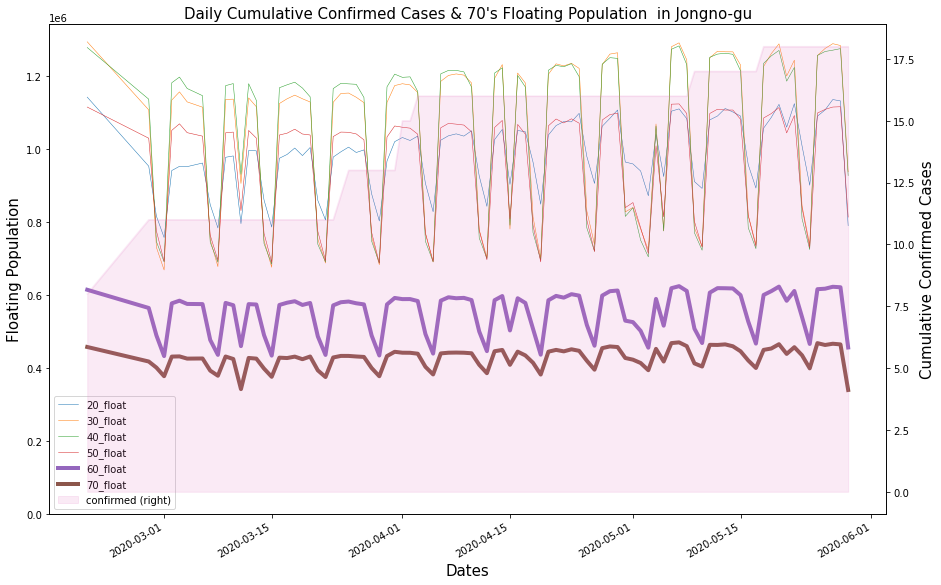

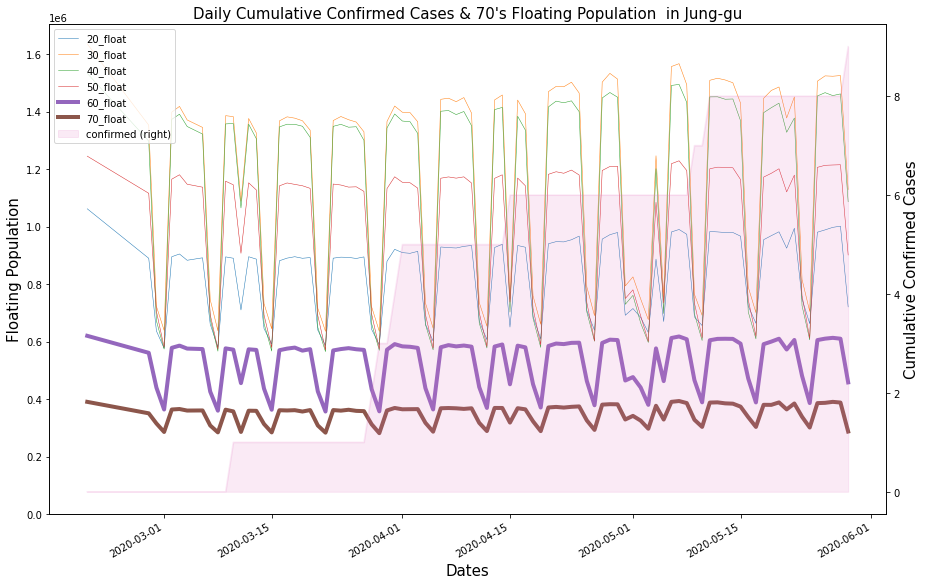

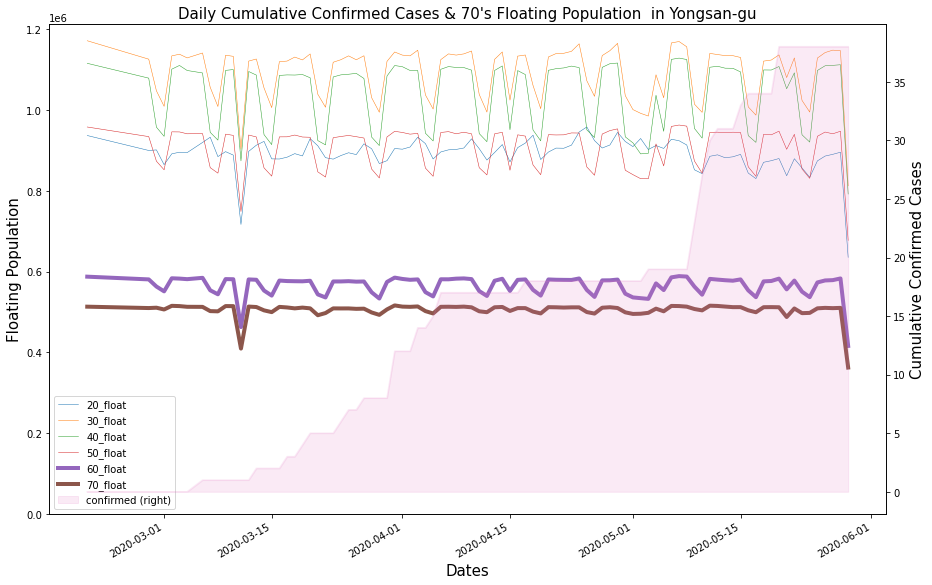

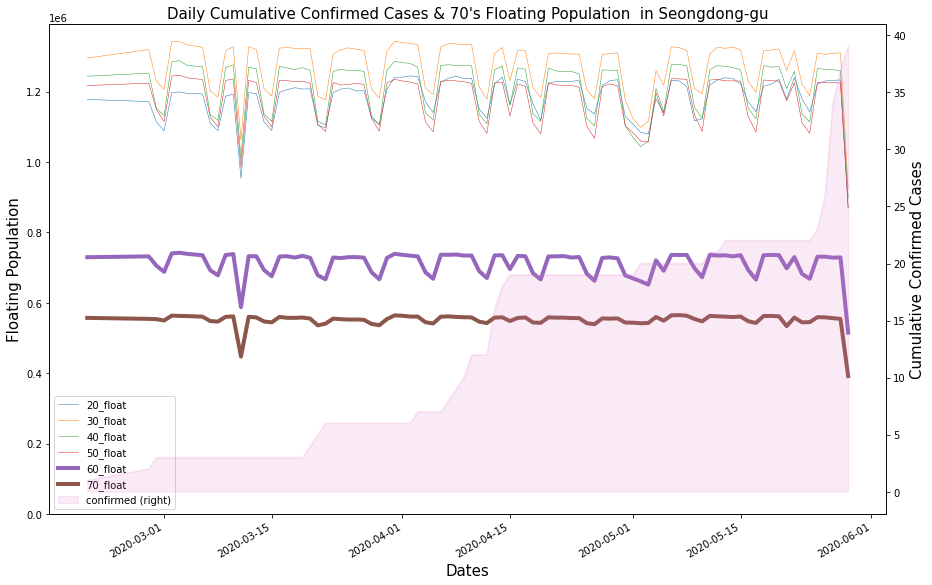

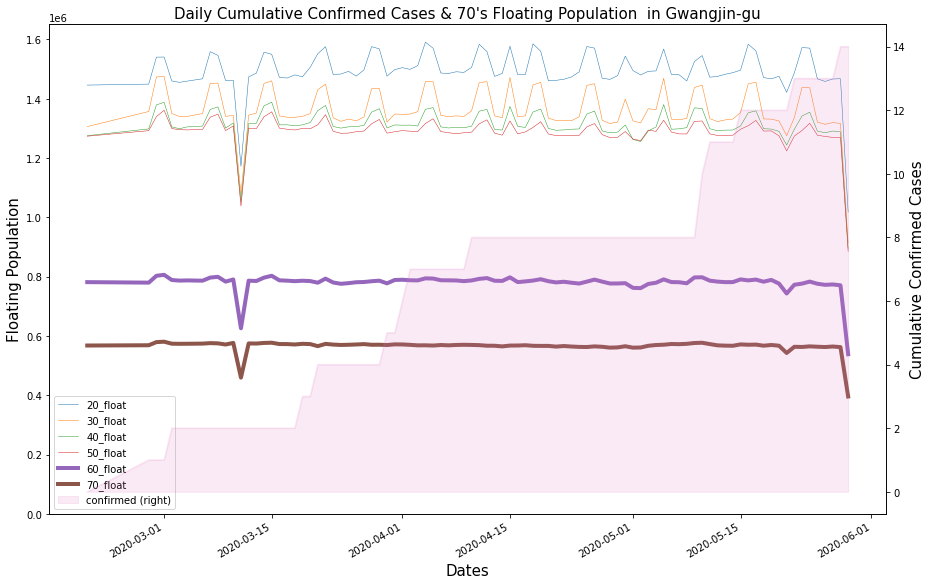

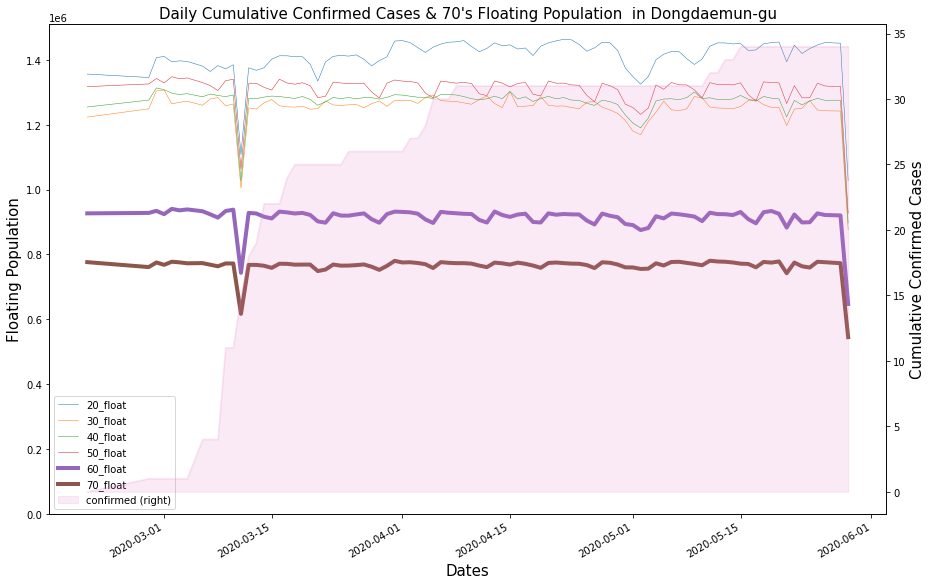

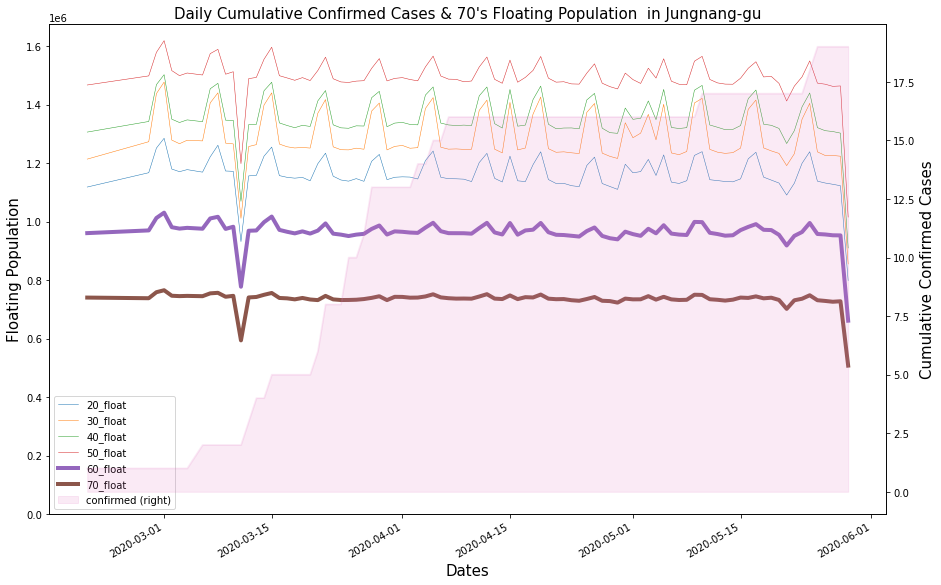

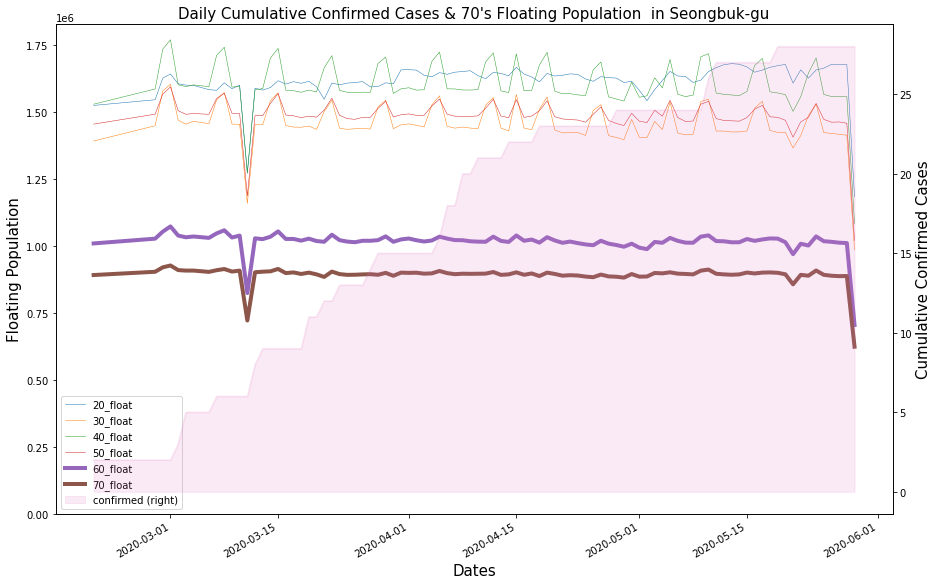

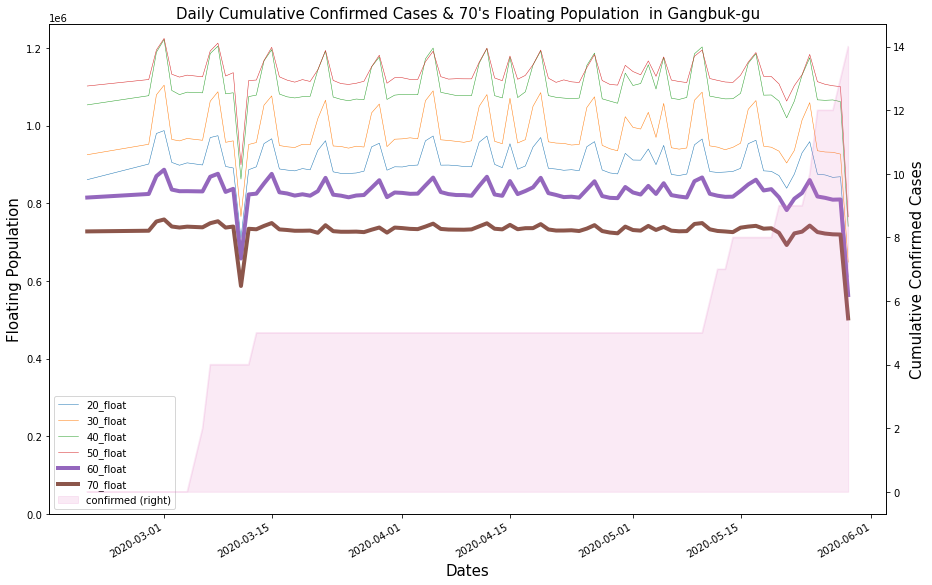

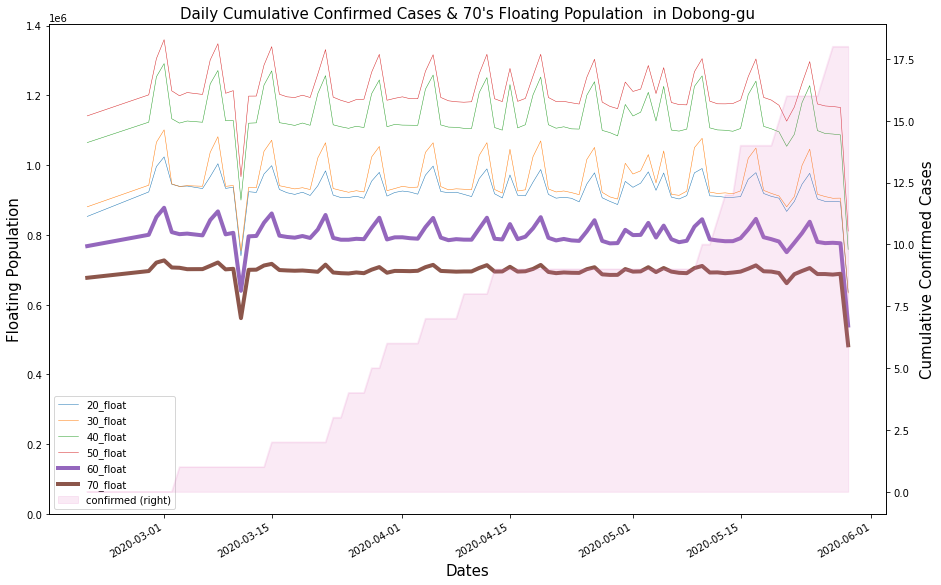

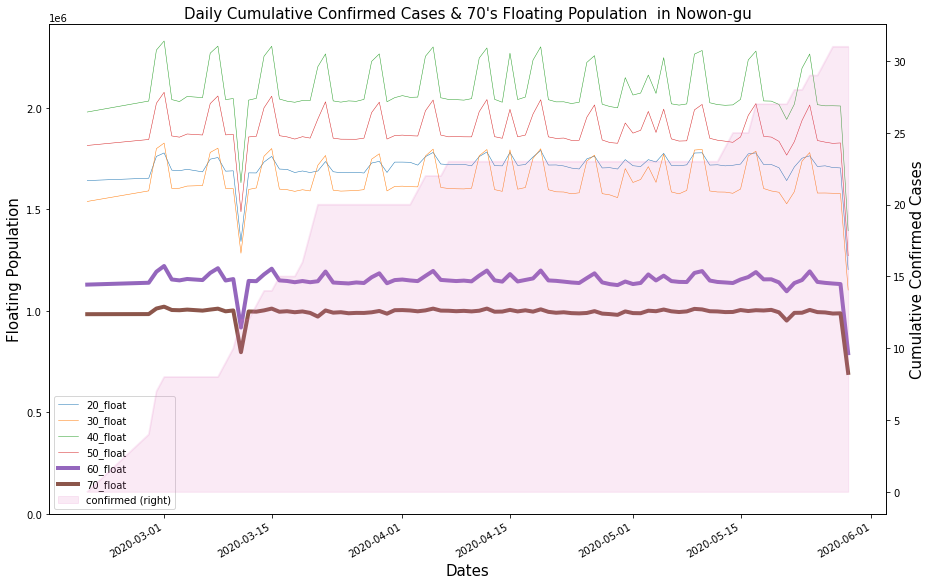

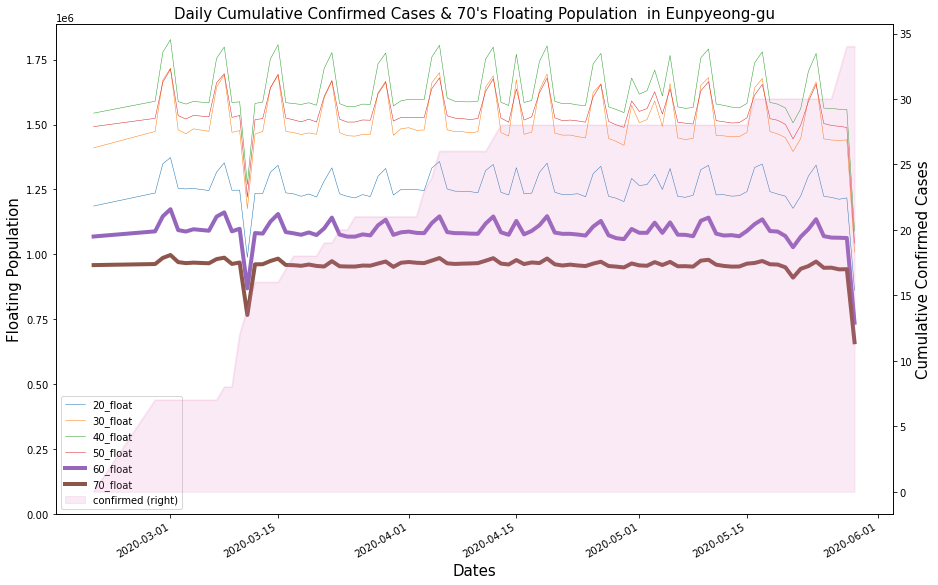

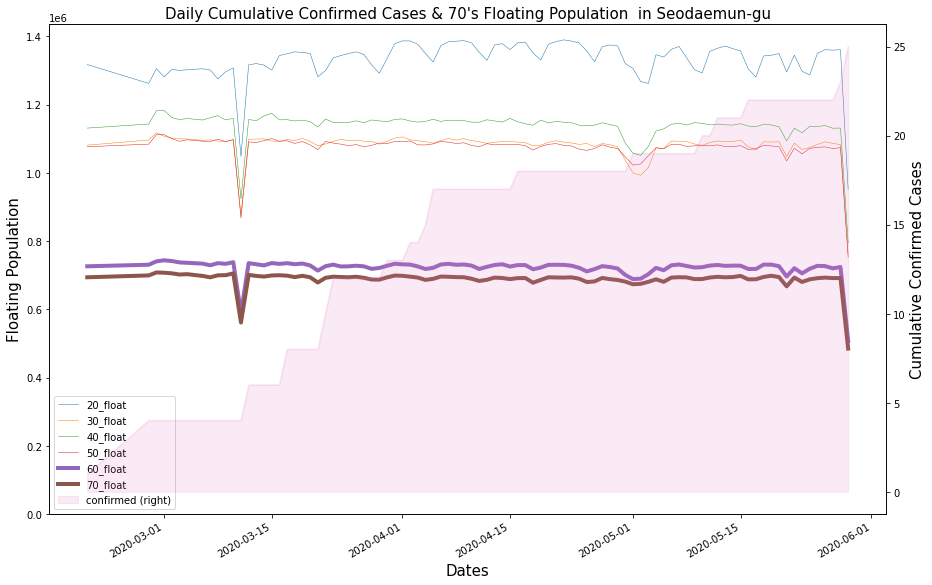

In [133]:
# 13개 구만 먼저 확인하기
for gu in gu_list[:13]:
    fig, ax = plt.subplots(figsize=(15, 10))
    for age in age_list:
        
        condition_1 = age_gu_float['birth_year'] == age
        condition_2 = age_gu_float['city'] == gu
        if age < 60:
            ax1 = age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=0.5)
        else:
            ax1 = age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=4)
    ax2 = age_gu_float[condition_1 & condition_2].plot(kind='area',
                                                     x='date',
                                                     y='confirmed',
                                                     label='confirmed',
                                                     secondary_y=True,
                                                     ax=ax,
                                                      alpha=0.15)
    
    ax.set_xlabel('Dates', fontsize=15)
    ax1.set_ylabel('Floating Population', fontsize=15)
    ax2.set_ylabel('Cumulative Confirmed Cases', fontsize=15)
    ax.set_title(f"Daily Cumulative Confirmed Cases & {age}'s Floating Population  in {gu}", fontsize=15)
plt.show()

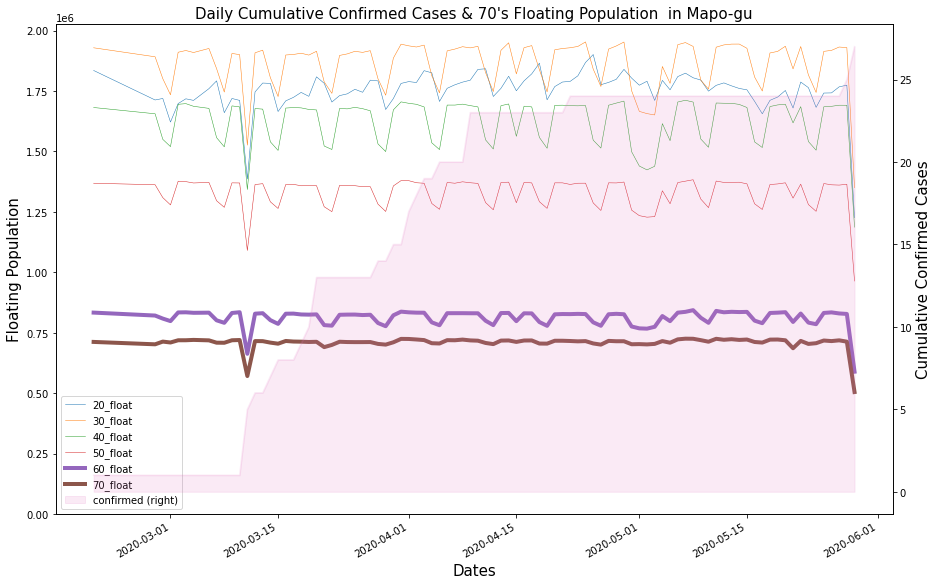

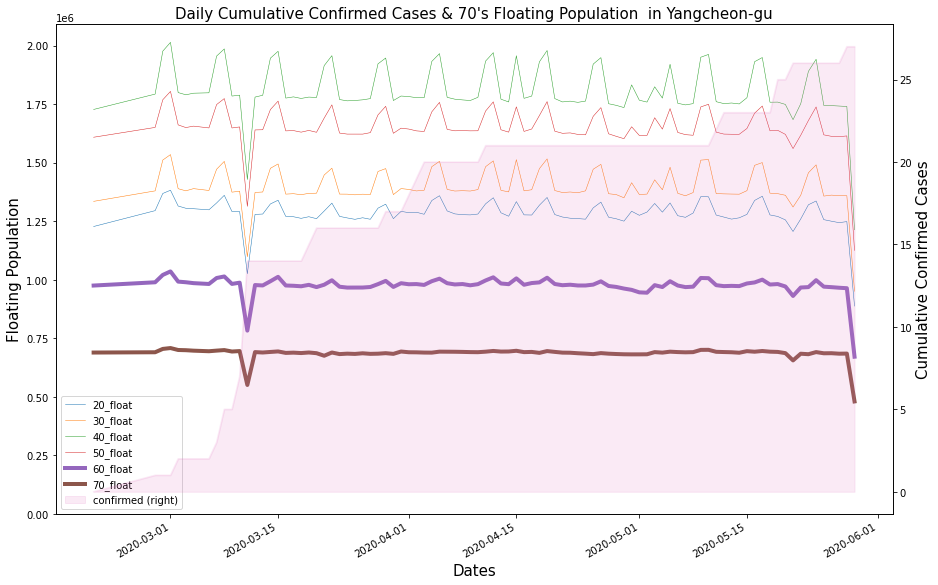

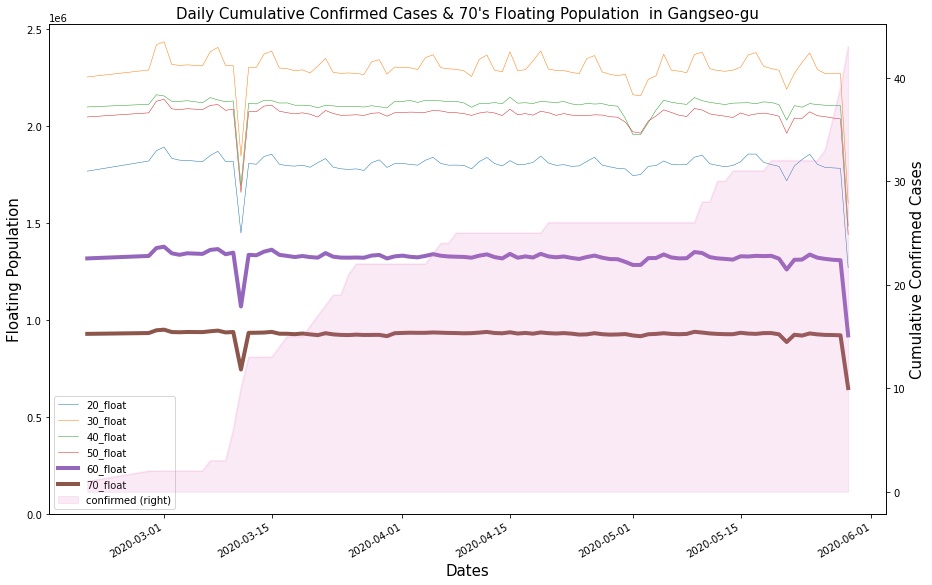

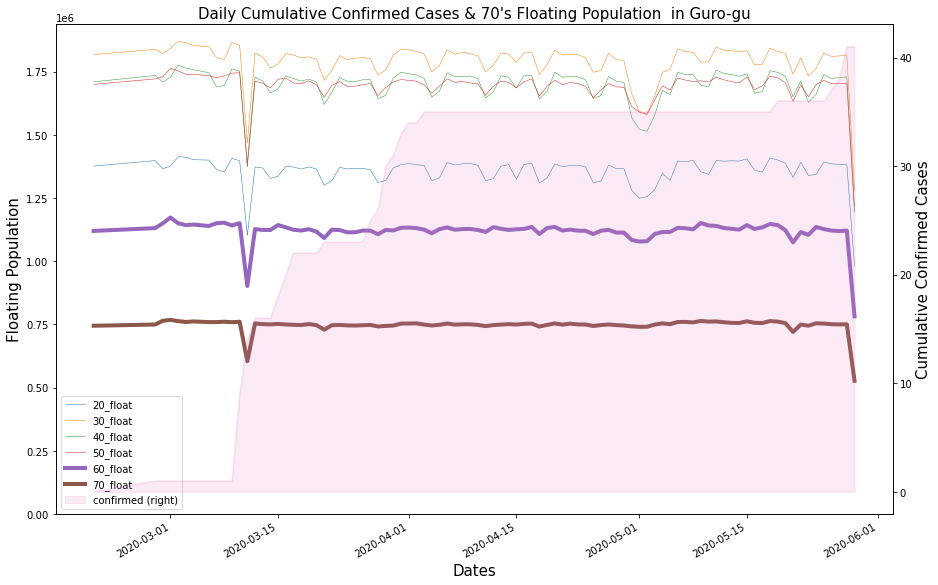

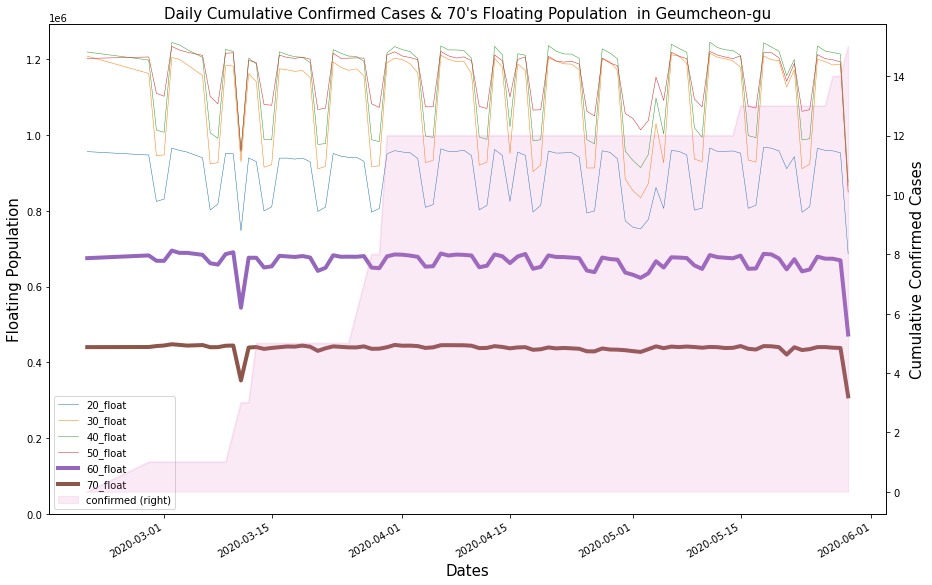

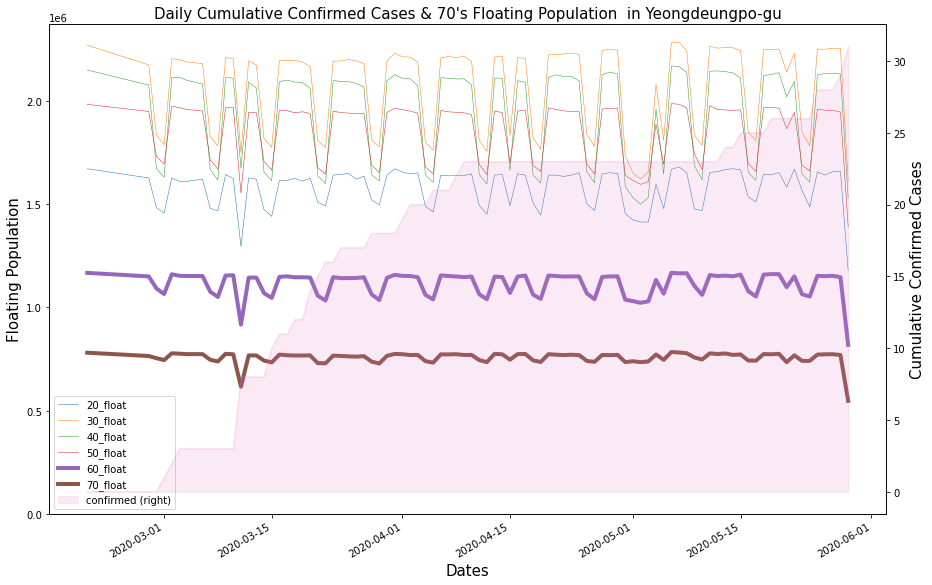

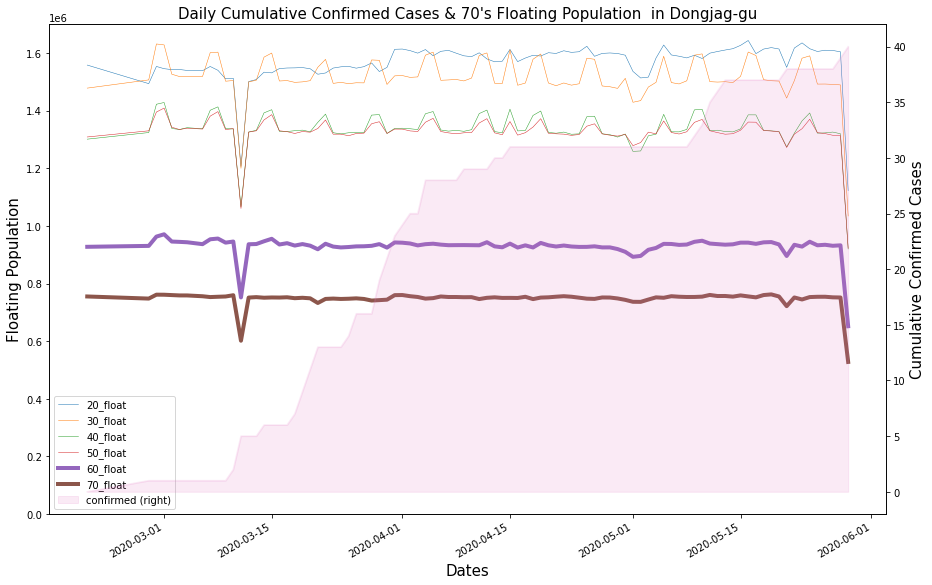

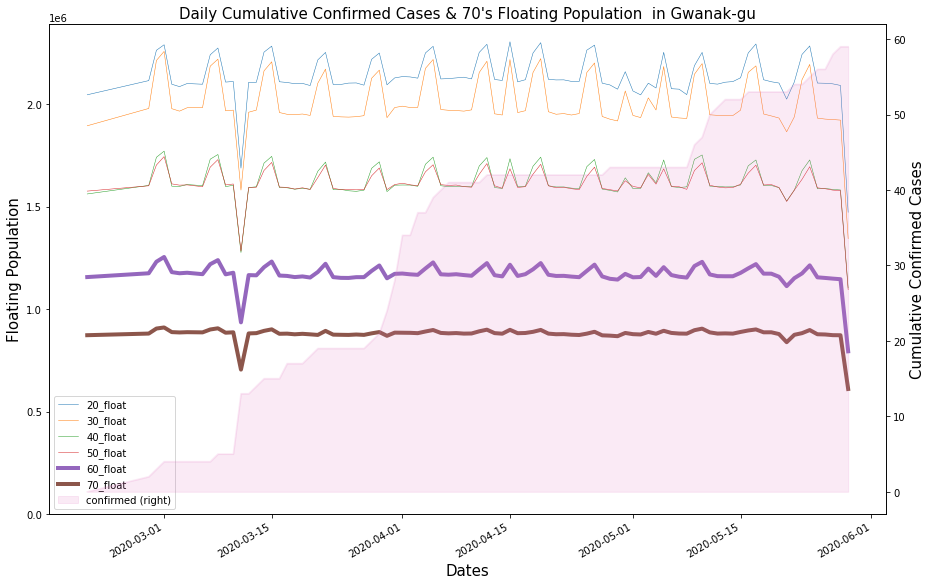

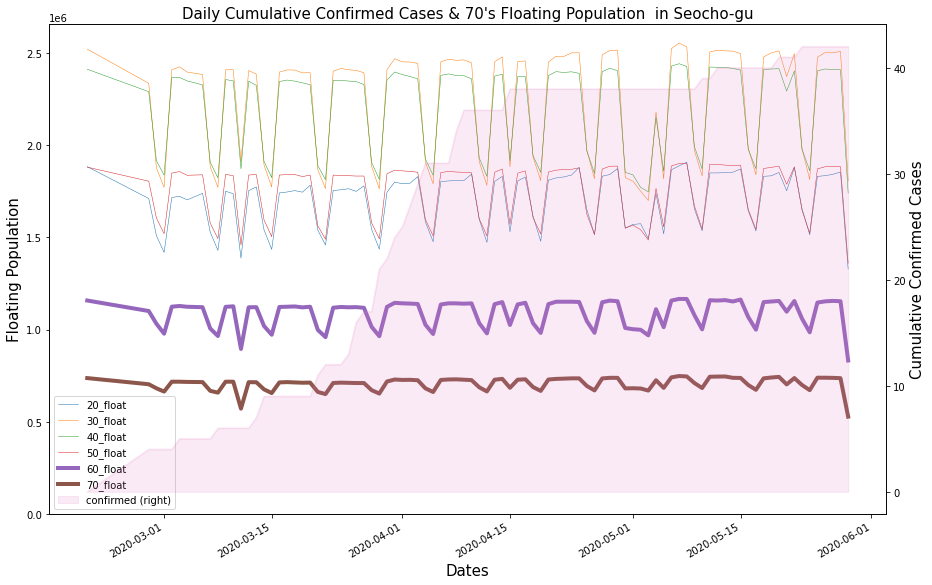

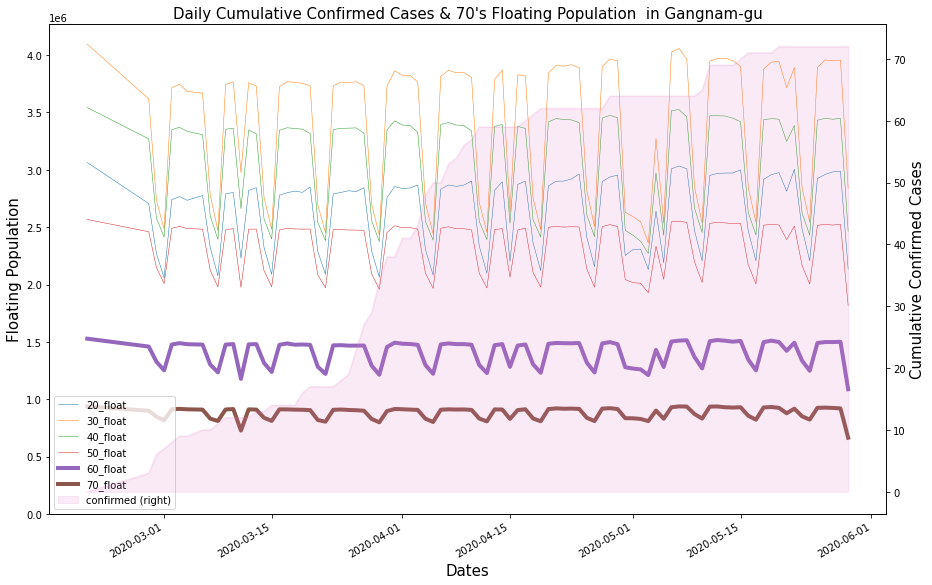

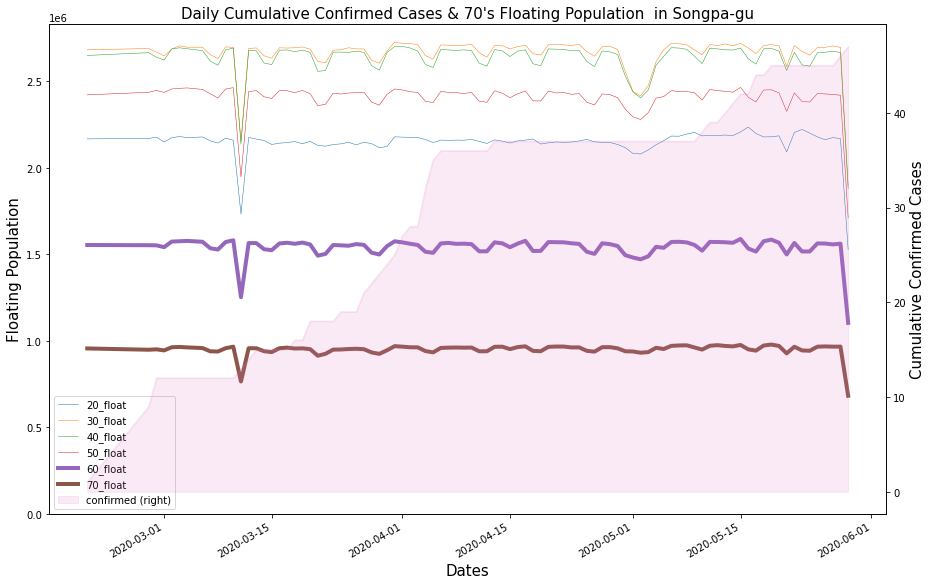

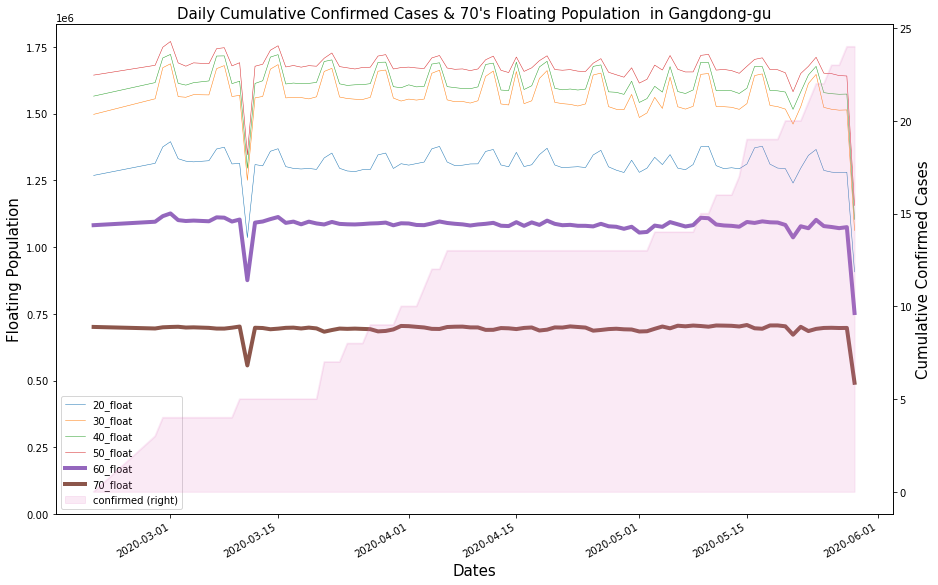

In [134]:
# 12개 구 확인하기
for gu in gu_list[13:]:
    fig, ax = plt.subplots(figsize=(15, 10))
    for age in age_list:
        
        condition_1 = age_gu_float['birth_year'] == age
        condition_2 = age_gu_float['city'] == gu
        if age < 60:
            ax1 = age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=0.5)
        else:
            ax1 = age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=4)
    ax2 = age_gu_float[condition_1 & condition_2].plot(kind='area',
                                                     x='date',
                                                     y='confirmed',
                                                     label='confirmed',
                                                     secondary_y=True,
                                                     ax=ax,
                                                      alpha=0.15)
    
    ax.set_xlabel('Dates', fontsize=15)
    ax1.set_ylabel('Floating Population', fontsize=15)
    ax2.set_ylabel('Cumulative Confirmed Cases', fontsize=15)
    ax.set_title(f"Daily Cumulative Confirmed Cases & {age}'s Floating Population  in {gu}", fontsize=15)
plt.show()

### 결론
---
연령대로 나뉘어서 확인했을 때에도 유동성의 감소세가 예상됐던 **고령층(60대, 70대)** 의 유동인구 감소가 확인되지 않았습니다. 누적확진자 수 증가는 전 연령층의 유동성에 큰 영향을 끼치지 않는 것으로 보입니다.

하지만 확진자 수 증가가 미미했던 코로나 발병 초기에는 어쩌면 `누적확진자 수`가 긴급재난문자로 알려지는 `일별 확진자 증가 수`보다 크게 와닿지 않았을 가능성도 있습니다. 일별 확진자 증가 수는 매일매일 새롭게 추가된 수로서 이전의 누적된 확진자 수와는 상관 없이 증가폭이 클수록 더 `임박한` 위험성으로 다가올 수 있기 때문입니다. 마지막으로 위의 시각화 자료를 **일별 확진자 증가 수**에 빗대어 확인해보도록 하겠습니다.

### 데이터 시각화 (4)
- 서울시 구별 일별 확진자 증가 수에 따른 연령병 유동인구 추이 파악
---

In [ ]:
# 먼저 빈 컬럼 생성해주기
gu_fpnum_confirmed['daily_increase'] = 0

In [153]:
# 각 구마다 일별 확진자 증가수를 계산해서 생성된 컬럼에 넣어주기
for gu in gu_list:
    gu_fpnum_confirmed.loc[(gu_fpnum_confirmed['city'] == gu), 'daily_increase'] = gu_fpnum_confirmed[(gu_fpnum_confirmed['city'] == gu)]['confirmed'] - gu_fpnum_confirmed[(gu_fpnum_confirmed['city'] == gu)]['confirmed'].shift(1).fillna(0)

In [154]:
# 결측치 있는지 확인
gu_fpnum_confirmed['daily_increase'].isna().sum()

0

In [155]:
# 데이터프레임 확인
gu_fpnum_confirmed

date             city  hour  birth_year   fp_num  confirmed  \
0    2020-02-20        Dobong-gu  3312       12960  5385440          0   
1    2020-02-20    Dongdaemun-gu  3312       12960  6854800          0   
2    2020-02-20       Dongjag-gu  3312       12960  7328200          0   
3    2020-02-20     Eunpyeong-gu  3312       12960  7660360          0   
4    2020-02-20       Gangbuk-gu  3312       12960  5482400          0   
...         ...              ...   ...         ...      ...        ...   
2295 2020-05-29     Seongdong-gu  1632        9180  4468680         39   
2296 2020-05-29        Songpa-gu  1632        9180  8801920         47   
2297 2020-05-29     Yangcheon-gu  1632        9180  5329550         27   
2298 2020-05-29  Yeongdeungpo-gu  1632        9180  7080190         31   
2299 2020-05-29       Yongsan-gu  1632        9180  3694630         38   

      daily_increase  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
2295             2.0  
2296             1.0  
2297             0.0  
2298             2.0  
2299             0.0  

[2300 rows x 7 columns]

In [158]:
# 데이터프레임 합치기
daily_age_gu_float = pd.merge(gu_fpnum_confirmed, temp_df, on=['date','city'])

# 생성된 컬럼 중 필요없는 것 삭제
daily_age_gu_float = daily_age_gu_float.drop(['hour', 'birth_year_x', 'fp_num_x'], axis=1)

# 컬럼 이름 전과 동일하게 바꾸기
daily_age_gu_float = daily_age_gu_float.rename(columns={'birth_year_y':'birth_year', 'fp_num_y':'fp_num'})

daily_age_gu_float

date        city  confirmed  daily_increase  birth_year   fp_num
0     2020-02-20   Dobong-gu          0             0.0          20   853080
1     2020-02-20   Dobong-gu          0             0.0          30   880750
2     2020-02-20   Dobong-gu          0             0.0          40  1064870
3     2020-02-20   Dobong-gu          0             0.0          50  1141420
4     2020-02-20   Dobong-gu          0             0.0          60   768080
...          ...         ...        ...             ...         ...      ...
13795 2020-05-29  Yongsan-gu         38             0.0          30   812180
13796 2020-05-29  Yongsan-gu         38             0.0          40   791820
13797 2020-05-29  Yongsan-gu         38             0.0          50   677120
13798 2020-05-29  Yongsan-gu         38             0.0          60   415930
13799 2020-05-29  Yongsan-gu         38             0.0          70   362440

[13800 rows x 6 columns]

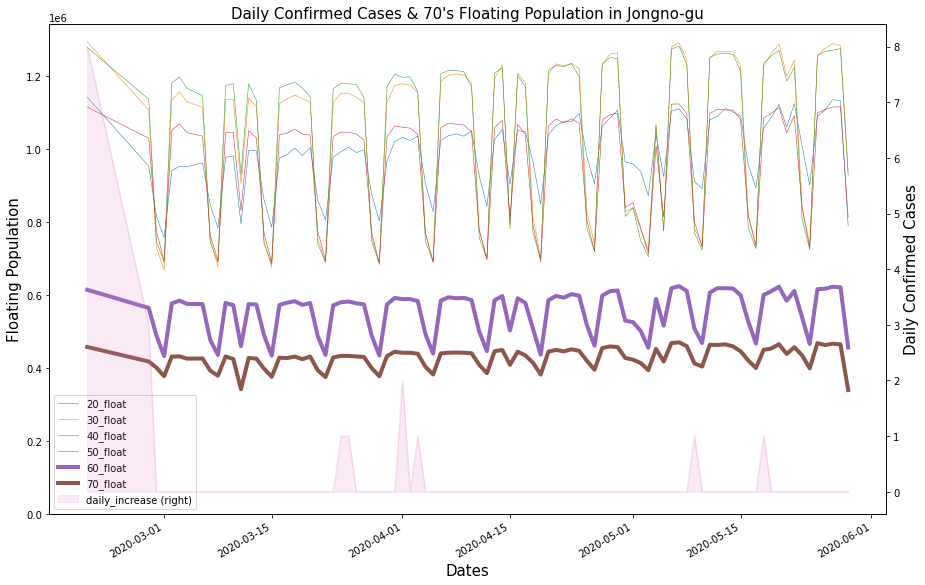

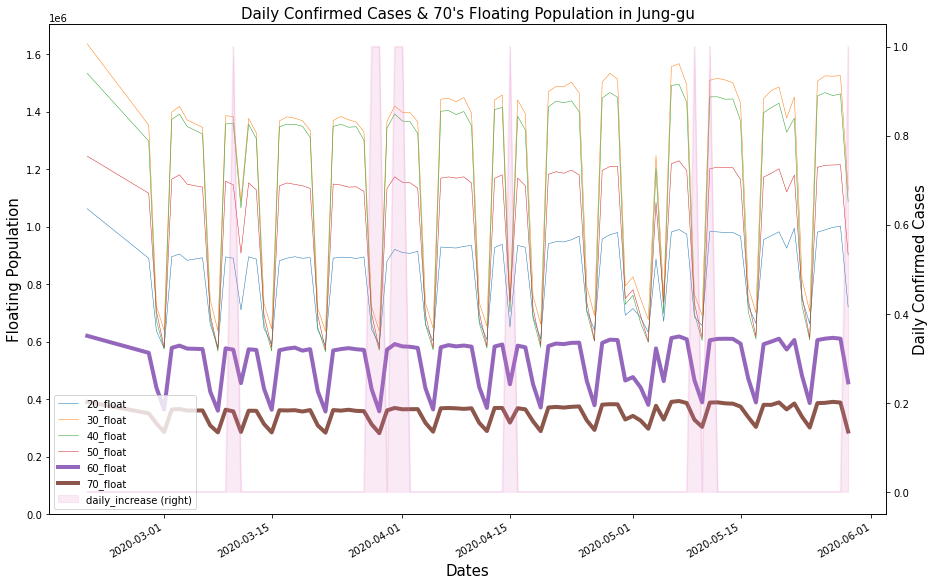

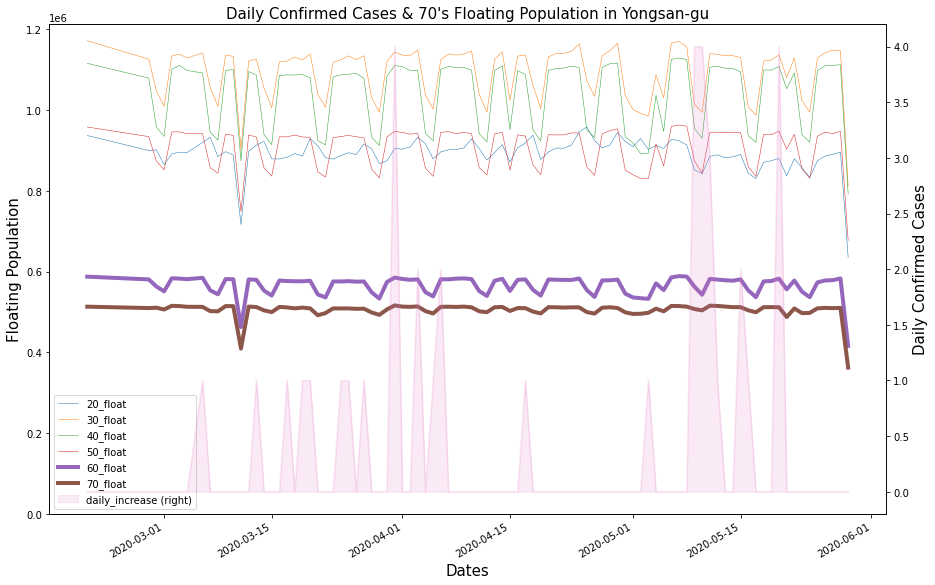

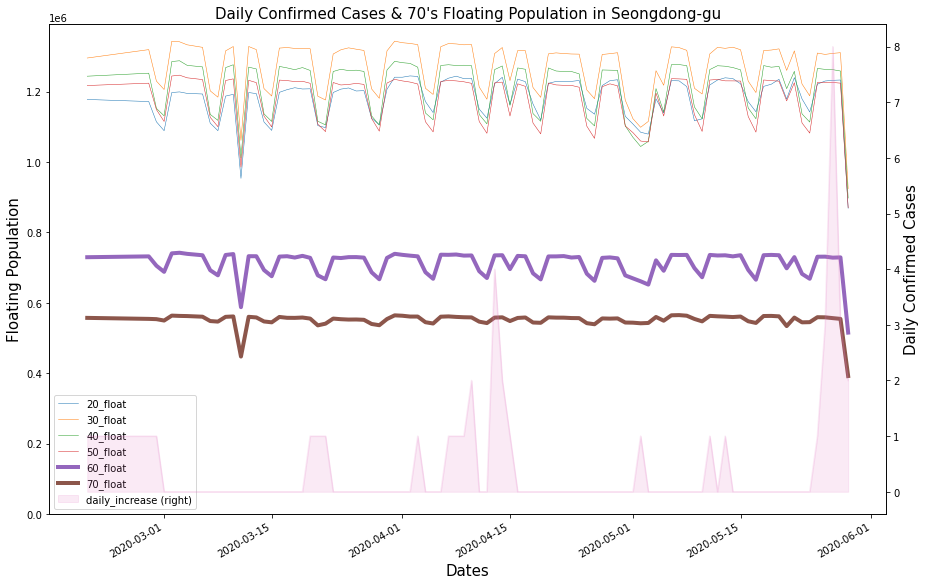

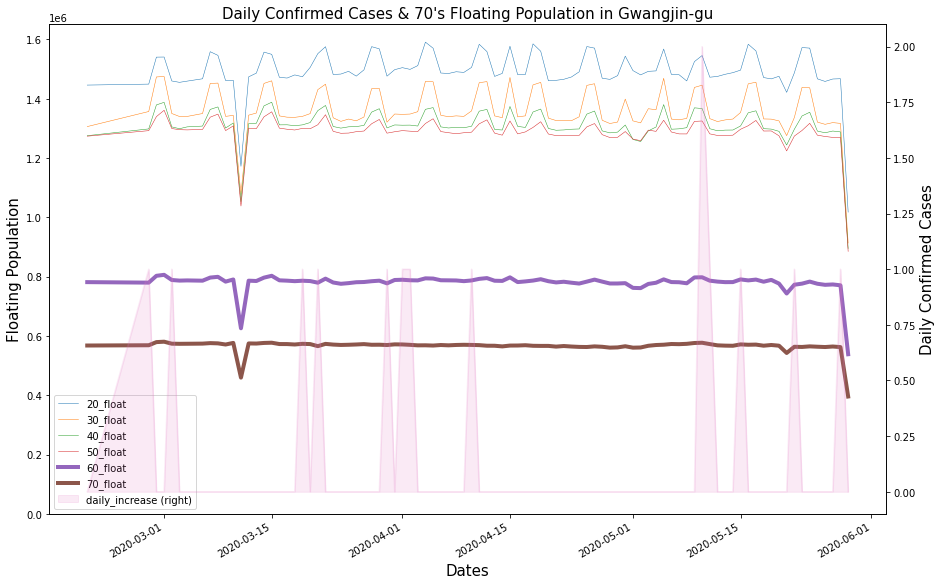

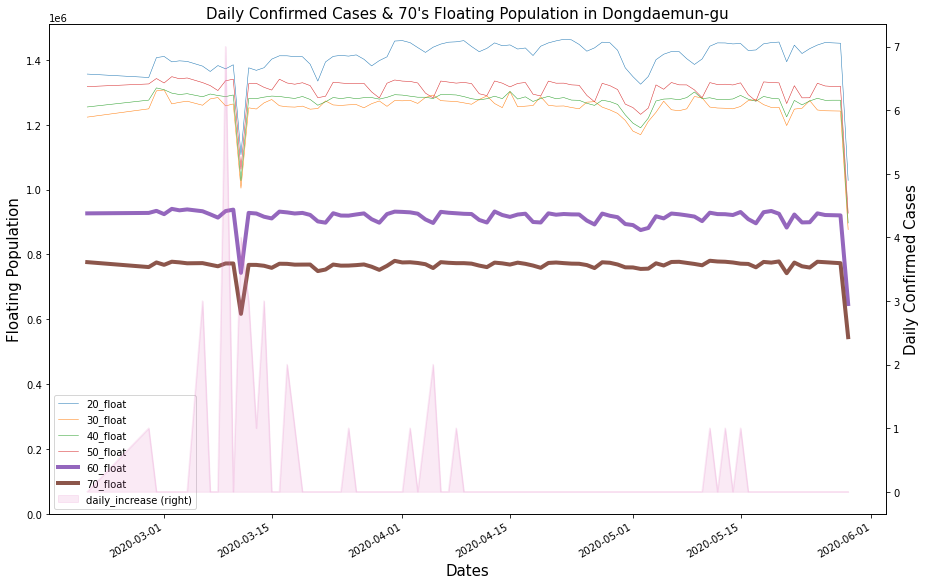

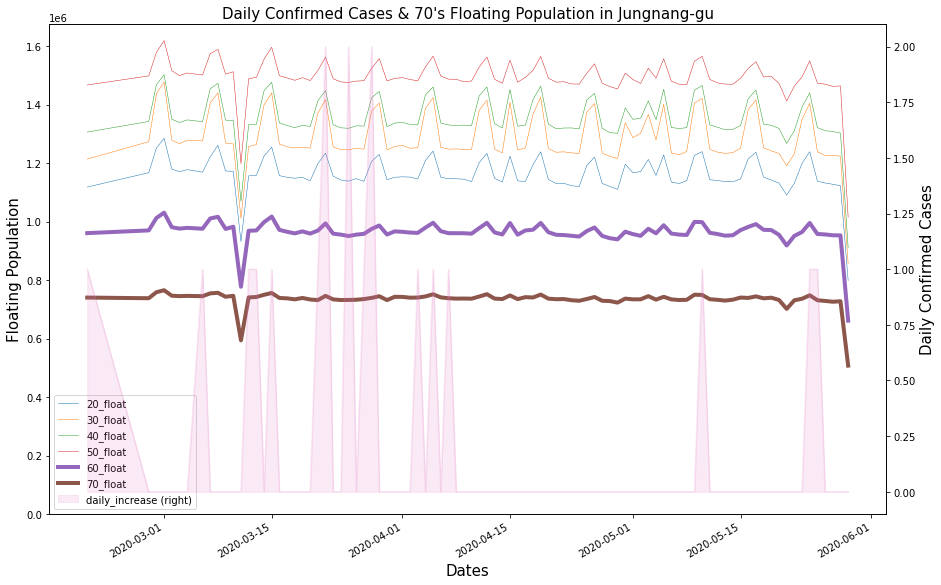

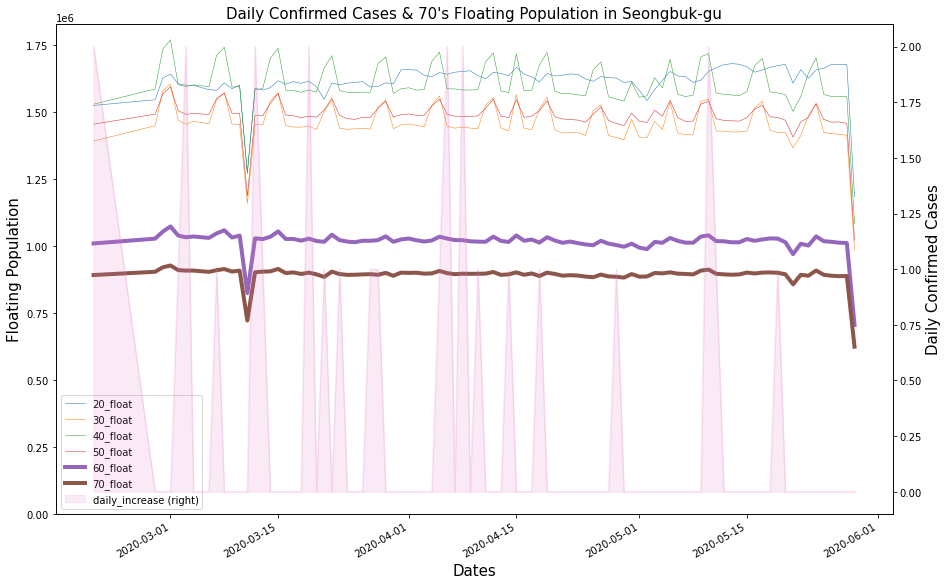

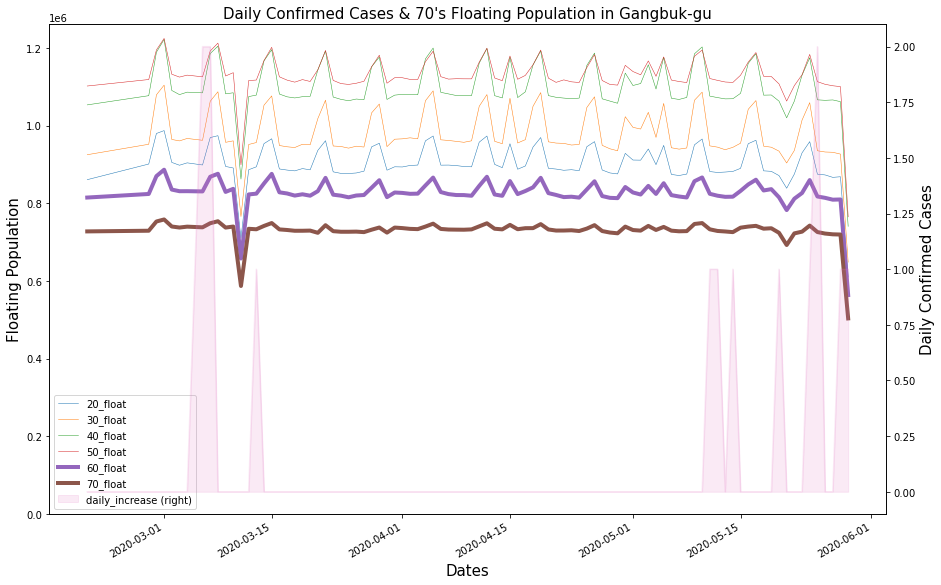

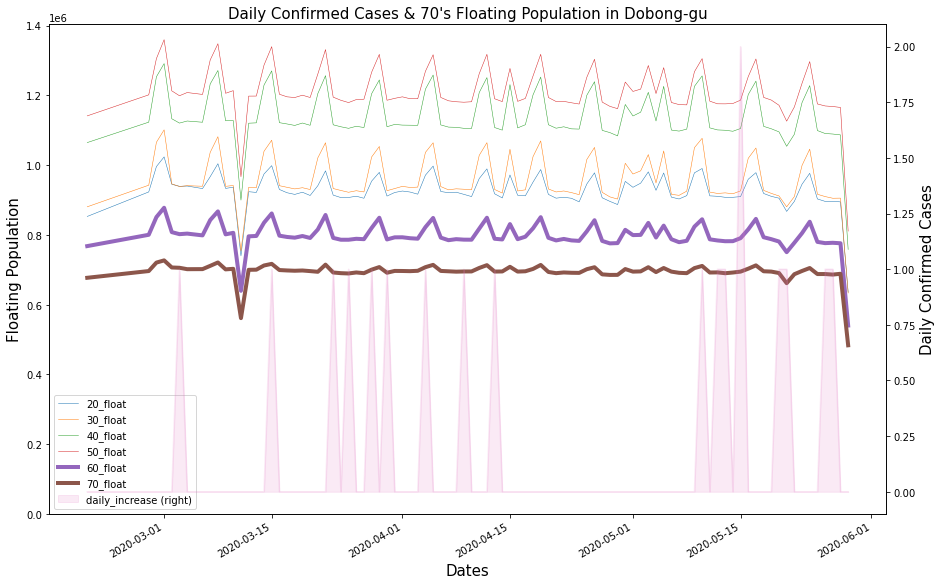

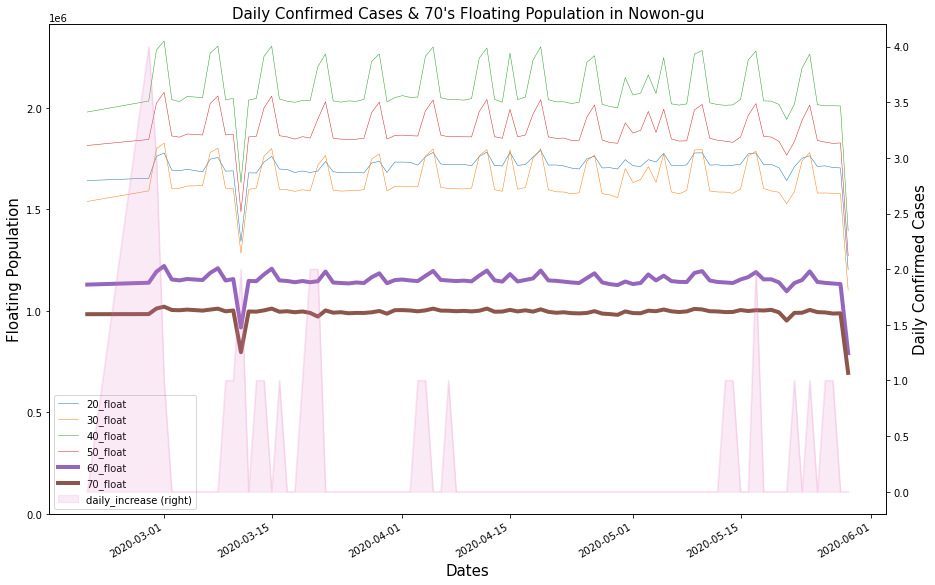

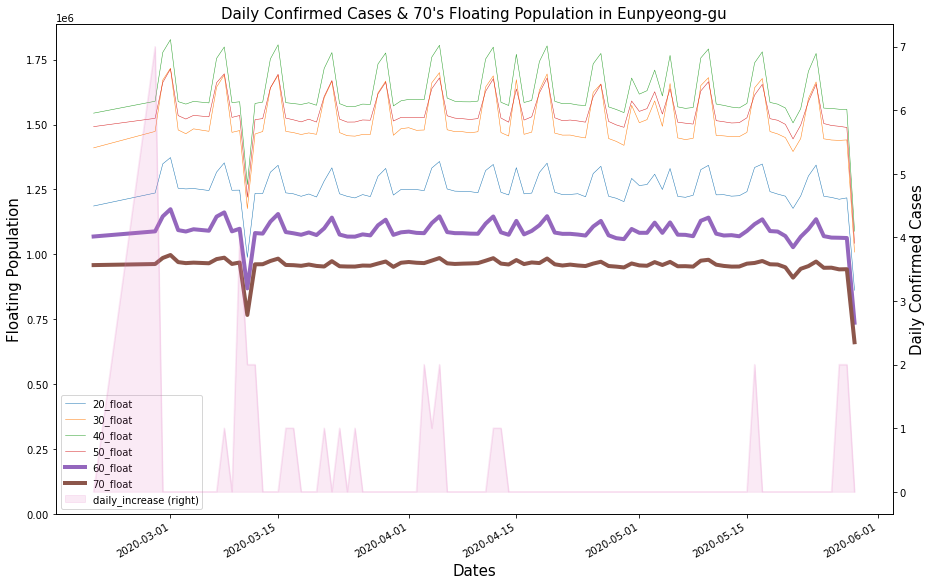

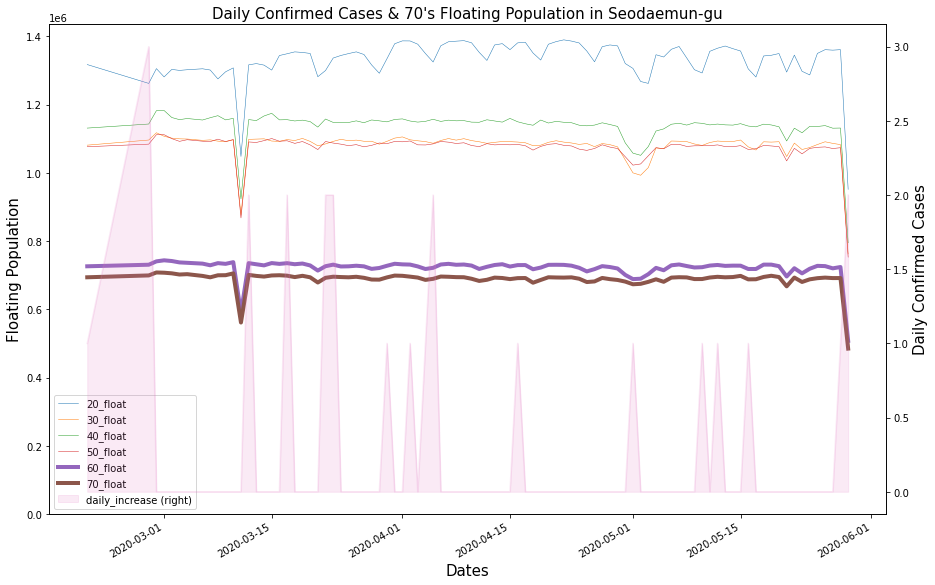

In [163]:
# 13개 구만 먼저 확인하기
for gu in gu_list[:13]:
    fig, ax = plt.subplots(figsize=(15, 10))
    for age in age_list:
        
        condition_1 = daily_age_gu_float['birth_year'] == age
        condition_2 = daily_age_gu_float['city'] == gu
        if age < 60:
            ax1 = daily_age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=0.5)
        else:
            ax1 = daily_age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=4)
    ax2 = daily_age_gu_float[condition_1 & condition_2].plot(kind='area',
                                                     x='date',
                                                     y='daily_increase',
                                                     label='daily_increase',
                                                     secondary_y=True,
                                                     ax=ax,
                                                      alpha=0.15)
    
    ax.set_xlabel('Dates', fontsize=15)
    ax1.set_ylabel('Floating Population', fontsize=15)
    ax2.set_ylabel('Daily Confirmed Cases', fontsize=15)
    ax.set_title(f"Daily Confirmed Cases & Floating Population per Ages in {gu}", fontsize=15)
plt.show()

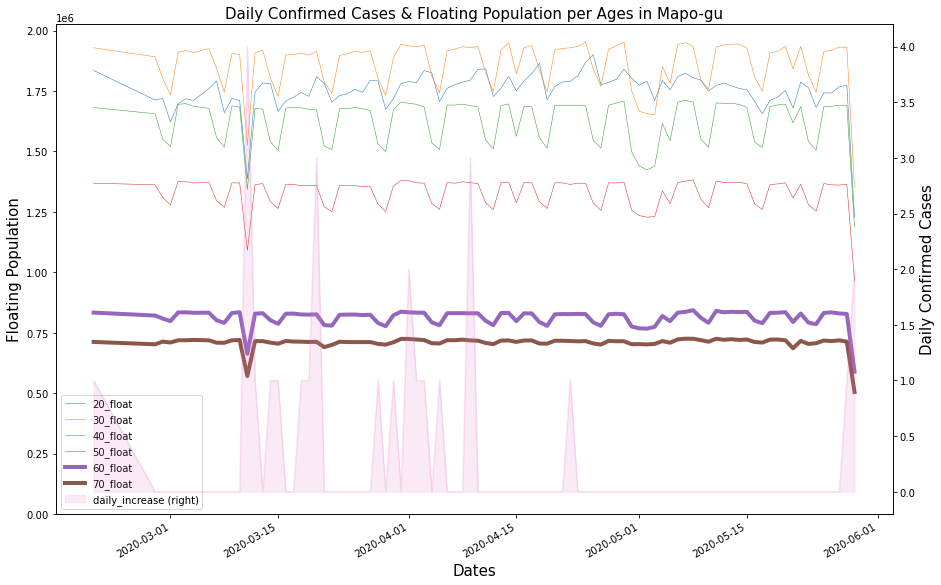

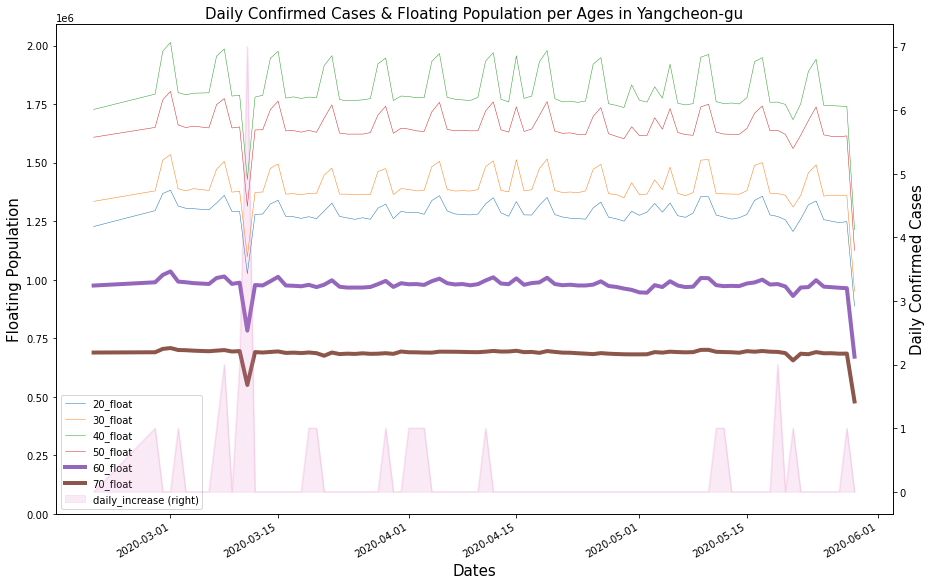

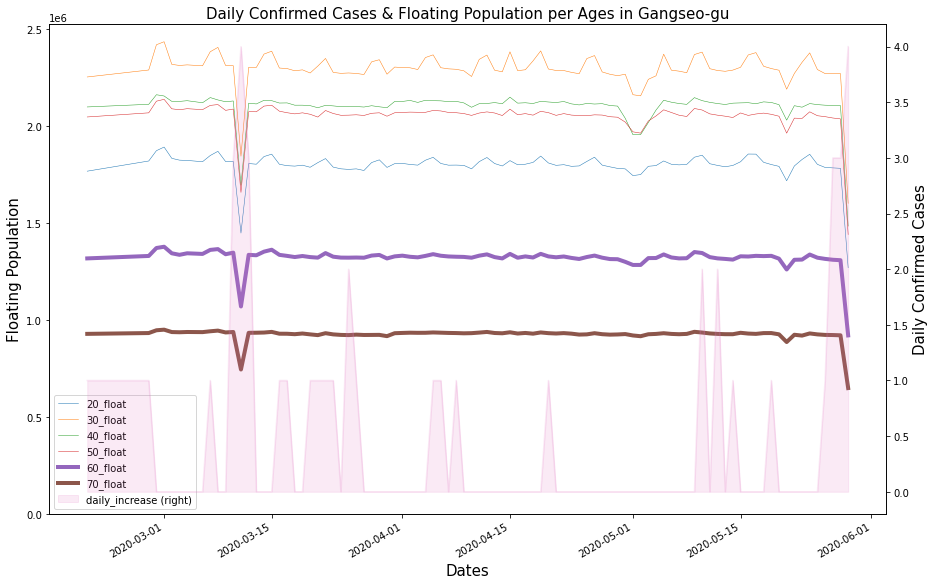

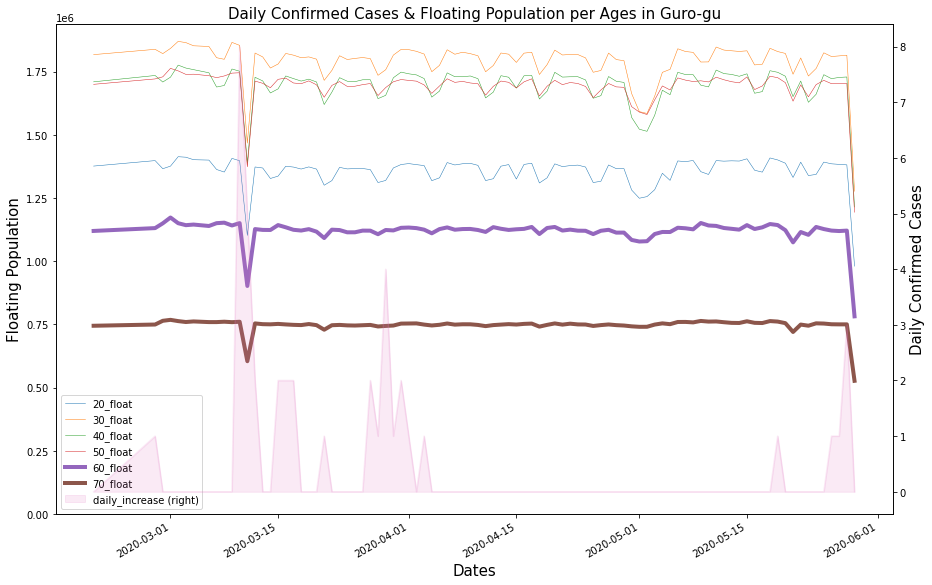

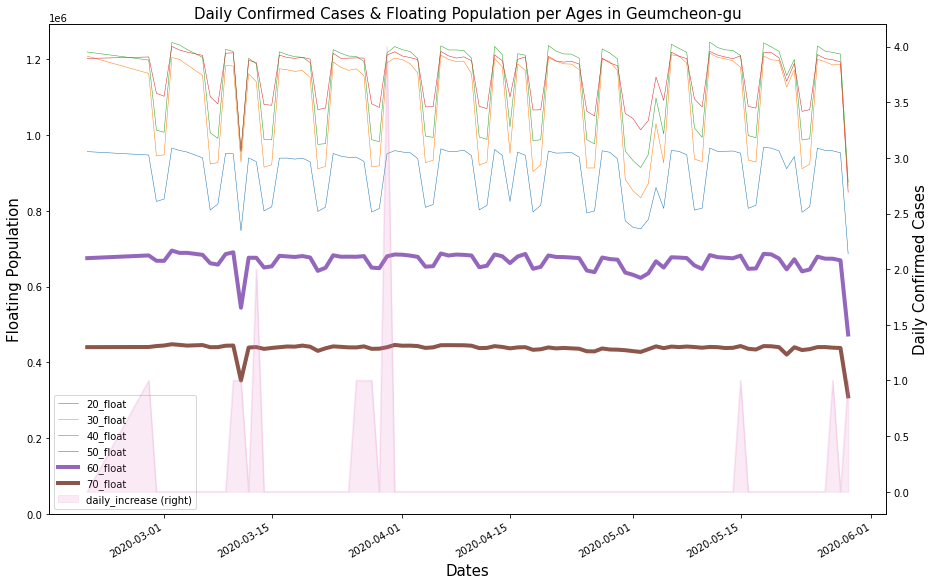

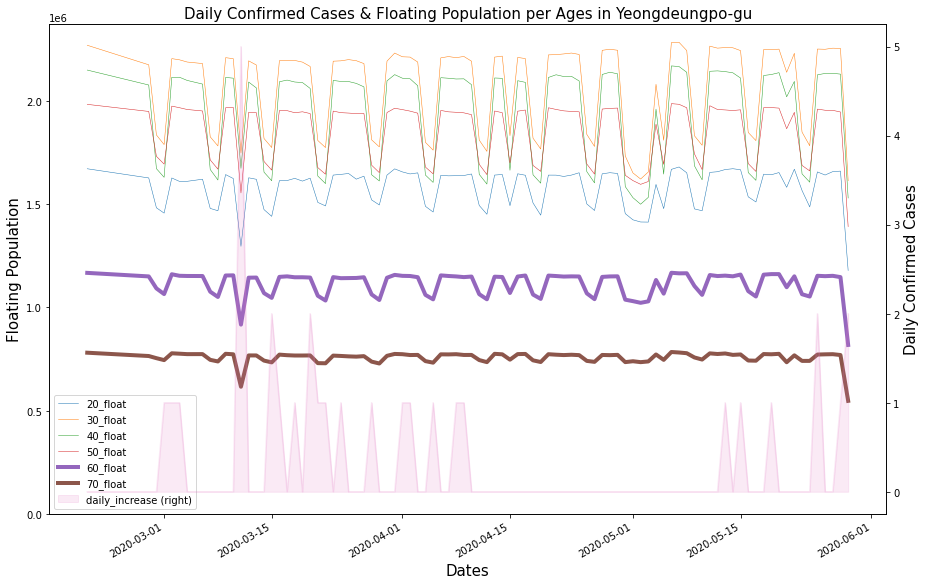

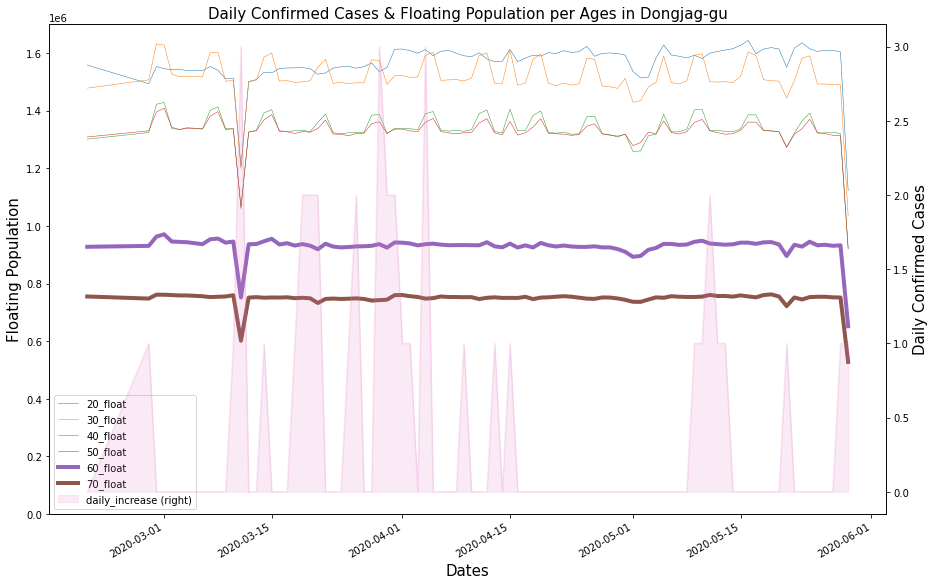

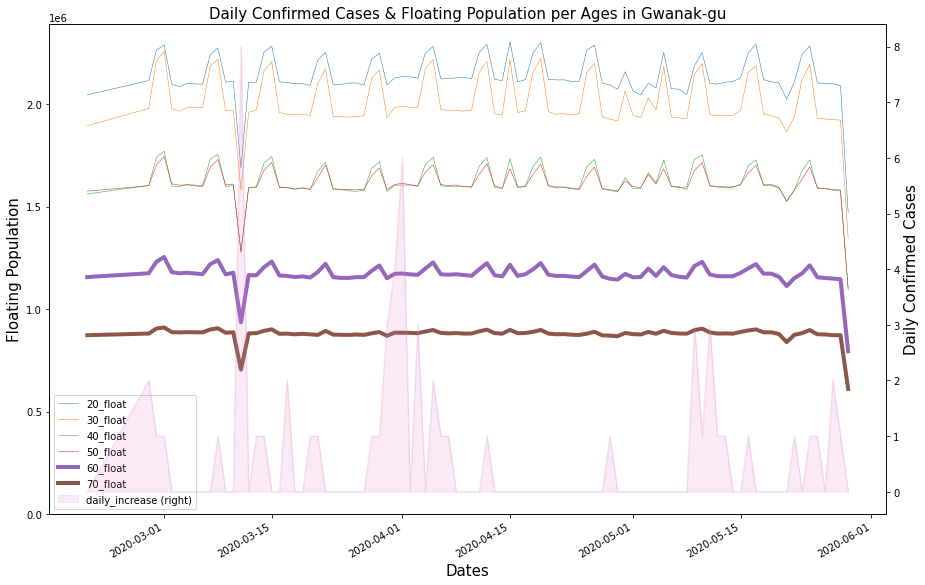

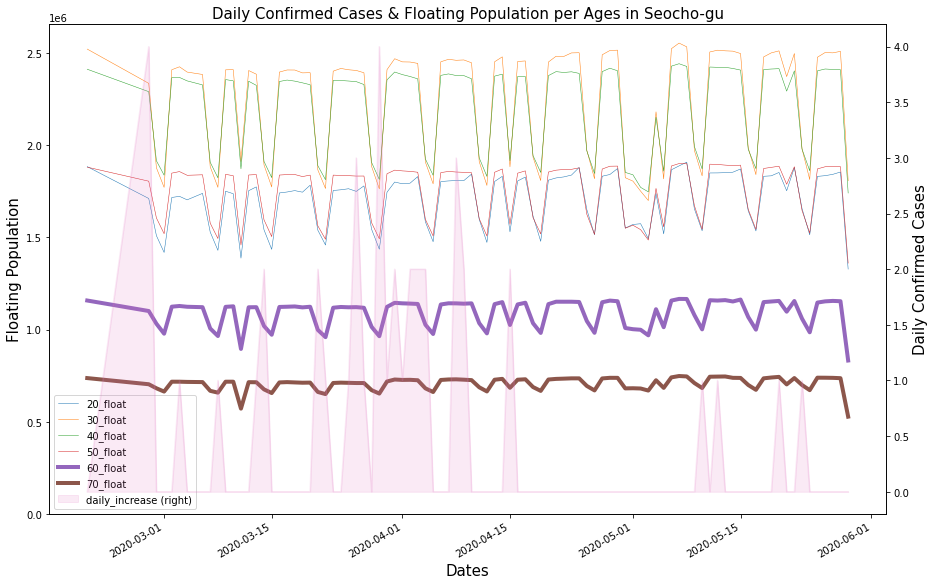

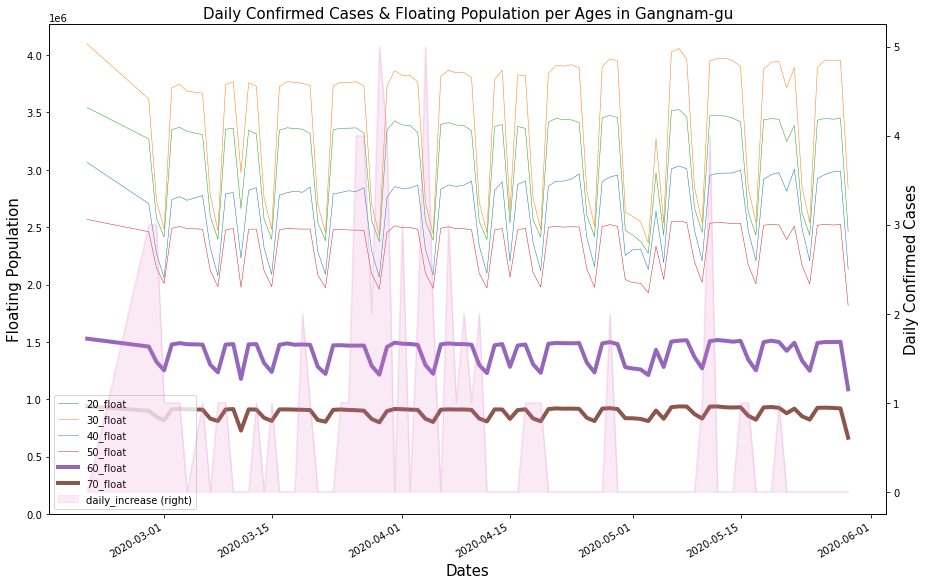

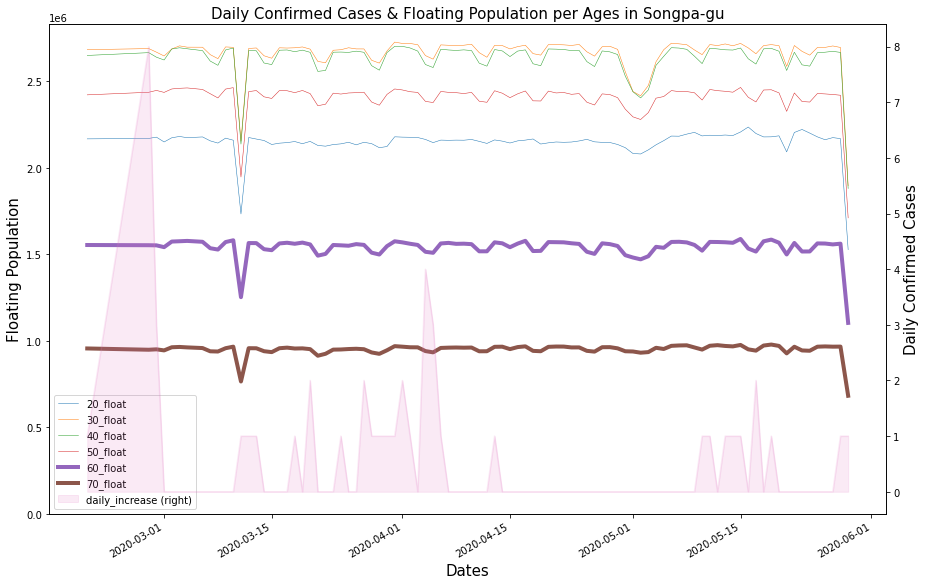

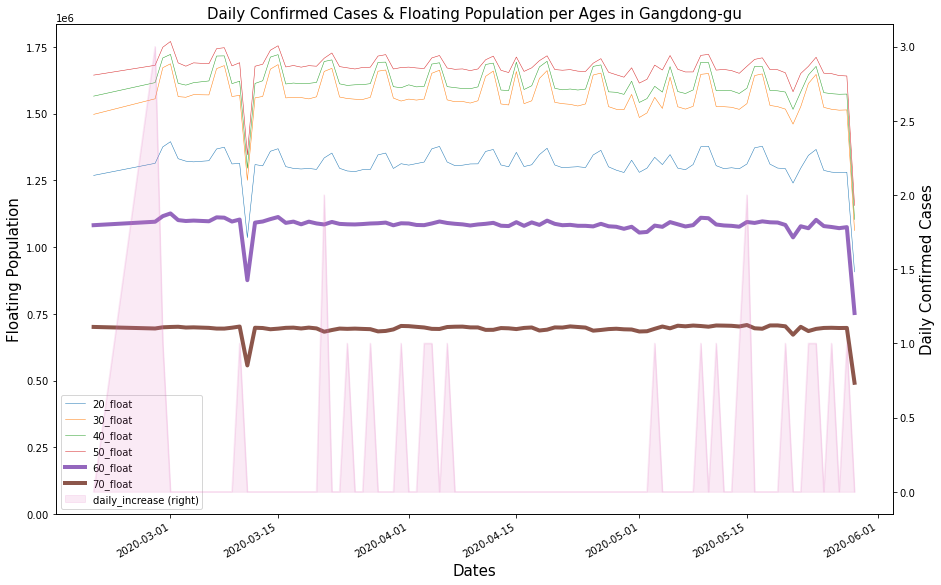

In [166]:
# 나머지 12개 구 확인하기
for gu in gu_list[13:]:
    fig, ax = plt.subplots(figsize=(15, 10))
    for age in age_list:
        
        condition_1 = daily_age_gu_float['birth_year'] == age
        condition_2 = daily_age_gu_float['city'] == gu
        if age < 60:
            ax1 = daily_age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=0.5)
        else:
            ax1 = daily_age_gu_float[condition_1 & condition_2].plot(kind='line',
                                                               x='date',
                                                               y='fp_num',
                                                               label=f'{age}_float',
                                                              ax=ax,
                                                              linewidth=4)
    ax2 = daily_age_gu_float[condition_1 & condition_2].plot(kind='area',
                                                     x='date',
                                                     y='daily_increase',
                                                     label='daily_increase',
                                                     secondary_y=True,
                                                     ax=ax,
                                                      alpha=0.15)
    
    ax.set_xlabel('Dates', fontsize=15)
    ax1.set_ylabel('Floating Population', fontsize=15)
    ax2.set_ylabel('Daily Confirmed Cases', fontsize=15)
    ax.set_title(f"Daily Confirmed Cases & Floating Population per Ages in {gu}", fontsize=15)
plt.show()

In [212]:
print("Each Gu's maximum daily increase and its date")
max_dates = []
gu_idx = []
for idx, gu in enumerate(gu_list):
    temp_sdf = daily_age_gu_float[daily_age_gu_float['city'] == gu][(daily_age_gu_float[daily_age_gu_float['city'] == gu]['daily_increase']) == (daily_age_gu_float[daily_age_gu_float['city'] == gu]['daily_increase'].max())]
    max_date = temp_sdf['date'].values[0]
    max_dates.append(max_date)
    gu_idx.append(idx)
    max_date_str = temp_sdf['date'].values[0].astype(str)[:10]
    max_increase =temp_sdf['daily_increase'].values[0]
    print(f"city: {gu}\n\tdate: {max_date_str}\n\tdaily_increase: {max_increase}")

Each Gu's maximum daily increase and its date
city: Jongno-gu
	date: 2020-02-20
	daily_increase: 8.0
city: Jung-gu
	date: 2020-03-10
	daily_increase: 1.0
city: Yongsan-gu
	date: 2020-03-31
	daily_increase: 4.0
city: Seongdong-gu
	date: 2020-05-27
	daily_increase: 8.0
city: Gwangjin-gu
	date: 2020-05-10
	daily_increase: 2.0
city: Dongdaemun-gu
	date: 2020-03-09
	daily_increase: 7.0
city: Jungnang-gu
	date: 2020-03-22
	daily_increase: 2.0
city: Seongbuk-gu
	date: 2020-02-20
	daily_increase: 2.0
city: Gangbuk-gu
	date: 2020-03-06
	daily_increase: 2.0
city: Dobong-gu
	date: 2020-05-15
	daily_increase: 2.0
city: Nowon-gu
	date: 2020-02-28
	daily_increase: 4.0
city: Eunpyeong-gu
	date: 2020-02-28
	daily_increase: 7.0
city: Seodaemun-gu
	date: 2020-02-28
	daily_increase: 3.0
city: Mapo-gu
	date: 2020-03-11
	daily_increase: 4.0
city: Yangcheon-gu
	date: 2020-03-11
	daily_increase: 7.0
city: Gangseo-gu
	date: 2020-03-11
	daily_increase: 4.0
city: Guro-gu
	date: 2020-03-10
	daily_increase: 8.0
c

In [211]:
pd.Series(max_dates).value_counts()

2020-02-28    6
2020-03-11    6
2020-02-20    2
2020-03-10    2
2020-03-31    1
2020-05-27    1
2020-05-10    1
2020-03-09    1
2020-03-22    1
2020-03-06    1
2020-05-15    1
2020-03-30    1
2020-03-29    1
dtype: int64

In [216]:
tem = pd.Series(max_dates)
tem[tem == '2020-02-28']

Int64Index([10, 11, 12, 21, 23, 24], dtype='int64')

2월 28일은 금요일로서 그 다음날이나 그 이후에 유동인구가 줄었어도 주말이 끼어있어서 확진자 수 증가가 유동인구에 끼치는 영향을 독립적으로 보기 어려워 3월 11일만 확인해보겠습니다. 3월 11일은 수요일이고, 당일 이후 이틀간의 감소세가 있었는지 확인해보겠습니다.

In [226]:
daily_age_gu_float[(daily_age_gu_float['date'] == '2020-03-12') | (daily_age_gu_float['date'] == '2020-03-13')]

date        city  confirmed  daily_increase  birth_year   fp_num
1950 2020-03-12   Dobong-gu          1             0.0          20   924000
1951 2020-03-12   Dobong-gu          1             0.0          30   936580
1952 2020-03-12   Dobong-gu          1             0.0          40  1120420
1953 2020-03-12   Dobong-gu          1             0.0          50  1198100
1954 2020-03-12   Dobong-gu          1             0.0          60   796070
...         ...         ...        ...             ...         ...      ...
2245 2020-03-13  Yongsan-gu          2             1.0          30  1125980
2246 2020-03-13  Yongsan-gu          2             1.0          40  1086190
2247 2020-03-13  Yongsan-gu          2             1.0          50   933120
2248 2020-03-13  Yongsan-gu          2             1.0          60   579680
2249 2020-03-13  Yongsan-gu          2             1.0          70   512240

[300 rows x 6 columns]

In [245]:
twodays_before_mean = daily_age_gu_float[((daily_age_gu_float['date'] == '2020-03-09') | (daily_age_gu_float['date'] == '2020-03-10')) & (daily_age_gu_float['city'] == 'Dobong-gu')]['fp_num'].mean()

In [246]:
twodays_after_mean = daily_age_gu_float[((daily_age_gu_float['date'] == '2020-03-12') | (daily_age_gu_float['date'] == '2020-03-13')) & (daily_age_gu_float['city'] == 'Dobong-gu')]['fp_num'].mean()

In [247]:
round(twodays_after_mean / twodays_before_mean * 100, 2)

99.22

In [263]:
td = pd.DataFrame(columns=['diff', 'hund'])

In [261]:
pd.DataFrame({'diff':[99], 'hund':[100]})

diff  hund
0    99   100

In [264]:
td.append(pd.DataFrame({'diff':[99], 'hund':[100]}), ignore_index=True)

diff hund
0   99  100

In [276]:
max_dates[0].astype(str)[:10] == '2020-02-20'

True

In [303]:
# 3월 11일이 최급증날인 구의 그 다음날 며칠 유동인구 감소세 확인
# 시각화를 위한 빈 데이터프레임 만들기
bar_df = pd.DataFrame(columns=['diff', 'compare'])
for i, gu in enumerate(gu_list):
    
    # 3월 11일이 max_date인 구들만 뽑기
    if max_dates[i].astype(str)[:10] == '2020-03-11':
        
        # 3월 9일 ~ 3월 10일 이틀간 해당 구의 평균 유동인구 수 계산
        twodays_before_mean = daily_age_gu_float[((daily_age_gu_float['date'] == '2020-03-09') | (daily_age_gu_float['date'] == '2020-03-10')) & (daily_age_gu_float['city'] == gu)]['fp_num'].mean()
        
        # 3월 12일 ~ 3월 13일 이틀간 해당 구의 평균 유동인구 수 계산
        twodays_after_mean = daily_age_gu_float[((daily_age_gu_float['date'] == '2020-03-12') | (daily_age_gu_float['date'] == '2020-03-13')) & (daily_age_gu_float['city'] == gu)]['fp_num'].mean()
        diff = round(twodays_after_mean / twodays_before_mean * 100, 2)

        bar_df = bar_df.append(pd.DataFrame({'diff':diff, 'compare':'difference'}, index=[gu]))
        bar_df = bar_df.append(pd.DataFrame({'diff':[100], 'compare':'full'}, index=[gu]))
    else:
        continue

# bar_df = bar_df.reset_index(drop=True)

In [304]:
bar_df

diff     compare
Mapo-gu          100.46  difference
Mapo-gu          100.00        full
Yangcheon-gu      99.50  difference
Yangcheon-gu     100.00        full
Gangseo-gu        99.49  difference
Gangseo-gu       100.00        full
Yeongdeungpo-gu   98.90  difference
Yeongdeungpo-gu  100.00        full
Dongjag-gu        99.51  difference
Dongjag-gu       100.00        full
Gwanak-gu         99.60  difference
Gwanak-gu        100.00        full

AttributeError: 'Rectangle' object has no property 'ylim'

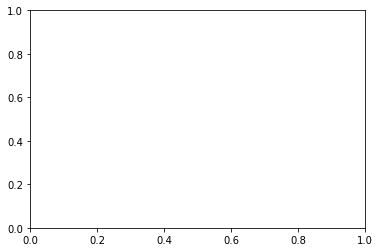

In [306]:
sns.barplot(data=bar_df, x=bar_df.index, y='diff', hue='compare', ylim=[90, 100])

### 결론
---

비교 대상을 `누적확진자 수`가 아닌 `일별 확진자 증가 수`로 바꿨을 때는 **구별 코로나 확진자 수 증가에 따르 연령대별 유동인구 감소 추세**가 눈에 띄는 구가 몇몇 확인됩니다. 전체 25개 구에 대해 각각 코로나 확진자 수가 **가장 급증했던 날**을 파악했을 때 약 절반 가량의 최급증날이 두 날짜(2월 28일, 3월 11일)에 몰리는데, 이 중 하나인 3월 11일의 경우 그 시점을 기준으로 대다수의 구에서 전연령층의 유동인구 감소세가 보이고 있습니다.

하지만 단순히 

203217220    1
199241850    1
199196700    1
189159070    1
191227460    1
            ..
197288070    1
197822170    1
198340770    1
198349480    1
188346500    1
Name: fp_num, Length: 132, dtype: int64

**따라서 SKT Big Data Hub에서 제공되는 서울시 유동인구 데이터를 토대로 했을 경우 해당 기간 내 사회적 거리두기는 코로나 확진자 수에 비례하여 잘 지켜지지 않았다고 볼 수 있을 것 같습니다.**
- 하지만, SKT Big Data Hub에서 제공되는 유동인구 데이터가 단순히 시그널이 잡히는 핸드폰 단말기 개수 같은 지표를 나타낼 경우, 서울에 거주하며 집에서 사회적 거리두기를 지키는 이들 역시 유동인구로 파악되어 데이터 분석에 오류가 생기게 된다.
- 그러나 데이터 원출처인 SKT Big Data Hub의 경우 현재 해당 사이트로의 접속 혹은 검색이 되지 않는 상태이며(2년 사이에 해당 사업부가 다른 것으로 바뀌지 않았나 추측), 캐글 페이지에서는 해당 유동인구가 어떻게 집계되었는지 설명된 기록을 찾기 어려웠다.
- 다음 분석에서는 해당 부분을 확인하여 이번 데이터 분석 결과의 타당함을 다시 한 번 판단해야 할 것 같다.